# Objective

Implement a neural network.


### Functions 

Implement functions to build a neural network.

* sigmoid
* softmax
* cross entropy log loss

### Layers

Implement neural network layers.

* Standardization
* Matmul
* Activation (sigmoid, softmax)
* Log loss output
* Batch normalization (TBD)



Mathjax formula not fully supported in github, hence the formulas get corrupted.


# References

* [CS231n: Convolutional Neural Networks for Visual Recognition 2017](http://cs231n.stanford.edu/2017/syllabus)
    - [cs231n 2017 assignment #1 kNN, SVM, SoftMax, two-layer network](https://cs231n.github.io/assignments2017/assignment1/)
    - [Training a Softmax Linear Classifier](https://cs231n.github.io/neural-networks-case-study)
* [ゼロから作る Deep Learning](https://github.com/oreilly-japan/deep-learning-from-scratch)
* [Mathematics for Machine Learning](https://mml-book.github.io/)

# Neural network overview

Structure of the network and how forward and backward propagations work.

<img src="image/nn_diagram.png" align="left">

# Objective function

The network trains the layers so as to minimize the objective function ```L``` which calculates the loss. Each layer at ```i``` is a function $f_i$ which takes an input $X_i$ from a previous layer and outputs $Y_i = f(X_i)$. The post layers of the form an objective function $L_i$ for the layer: $L = L_i(Y_i)$. 

## Forward path

Each layer ```i``` calculate its output $Y_i = f(X_i)$ and forward it to the next layer(s) as their input $X_{i+1}$.  

## Backward path

Automatic differentication, or *Back-Propagation*, is a process of calculating the gradient $\frac {\partial L_i(Y_i)}{\partial Y_i}$, that is, how much impact will $Y_i$ will make on the objective ```L``` when it changes. With the gradient, we can apply the gradient descent $X_i = X_i - \lambda  \frac {\partial L_i(Y_i)}{\partial Y_i} \frac {\partial Y_i }{\partial X_i}$ to update $X_i$ that would reduce the objective ```L```.

## Cycle

A cycle of forward-backward path with a batch data set $(X, T)$.


<img src="image/nn_functions.png" align="left">

# Setup

In [42]:
from typing import (
    Optional,
    Union,
    List,
    Dict,
    Tuple,
    Callable
)

### Python path
Python path setup to avoid the relative imports.

In [43]:
import sys
import os 

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

### Package dependencies

In [44]:
import inspect
from functools import partial
import logging
import numpy as np
import matplotlib.pyplot as plt

### Jupyter notebook

In [45]:
#!conda install line_profile memory_profiler
%load_ext memory_profiler
%load_ext line_profiler

# Logging is enabled by calling logging.basicConfig
# logging.basicConfig(stream=sys.stdout, level=logging.ERROR)
# Logger = logging.getLogger("neural_network")

%load_ext autoreload
%autoreload 2

The memory_profiler extension is already loaded. To reload it, use:
  %reload_ext memory_profiler
The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler
The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Matplotlib

In [46]:
import matplotlib.style as mplstyle
mplstyle.use('fast')
plt.ion()

# Note: with notebook backend from the top, updating the plot line does not work...
%matplotlib notebook
# %matplotlib inline

### numpy

In [47]:
np.set_printoptions(threshold=sys.maxsize)
np.set_printoptions(linewidth=80) 

## Network geometry

In [48]:
N = 1    # Batch size
D = 3    # Number of features in the input data
M = 2    # Number of nodes in a layer

---

# Confiurations 

## X
X is to have been standardized. 

## T
Labels for data X.

### For One Hot Encoding labels
$
\begin{align*}
\overset{ (N,M) }{ T_{_{OHE}} } &= ( 
    \overset{ (M,) }{ T_{(n=0)} }, \; \dots \;, \overset{ (M,) }{ T_{(n=N-1)} } 
) 
\\
\overset{ (N,M) }{ T_{_{OHE}} } = ( 
    \overset{ (M,) }{ T_{(n=0)} }, \dots , \overset{ (M,) }{ T_{(n=N-1)} } 
) 
\\
\overset{ (M,) }{ T_{ _{OHE} (n)} } &= ( \overset{ () }{ t_{(n)(m=0)} }, \; \dots \;, \overset{ () }{ t_{(n)(m=M-1)} })
\end{align*}
$

### For index labels
$
\begin{align*}
\overset{ (N,) }{ T_{_{IDX}} } &= (\overset{ () }{ t_{(n=0)} }, \; \dots \;, \overset{ () }{ t_{(n=N-1)} }) \qquad \text {for index labels }
\end{align*}
$

## W
Weight parameters.

In [49]:
from common import (
    xavier,
    he,
    uniform
)

---

# Normalization Layer
Apply normalization or use batch normaliation.

---

# Matmul layer

In [50]:
from layer.matmul import Matmul

## Objective Function
$
\begin{align*}
\overset{ (N,M) }{ Y } 
&= 
\begin{bmatrix}
{ Y_{(n=0)} } \\
\vdots \\
{ Y_{(n)} } \\
\vdots \\
{ Y_{(n=N-1)} }
\end{bmatrix}
=
\overset{ (N,D) }{ X } \; @ \; \overset{ (D,M) }{ W^T }
\\
\\
\overset{ (M,) }{ Y_{(n)} } &= (y_{(n)(m=0)}, \; \dots, \; y_{(n)(m)},  \; \dots, \; y_{(n)(m=M-1)})
\\
\overset{ () }{ y_{(n)(m)} }
&= \overset{ (D,) }{ X_{(n)} } \cdot \overset{ (D,) }{ W_{(m)}^T }
= \sum\limits ^{D}_{d=0}  \overset{ () }{ x_{(n)(d)} } * \overset{ () }{ w_{(m)(d)} }
\\
_{(0 \le d \le D, \; 0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Gradient dL/dX

Impact on L by $dX$.

$
\begin{align*}
\overset { (N,D) }{ \frac {\partial L }{ \partial X } }
= \overset { (N,M) }{ \frac {\partial L}{\partial Y} }
@ \overset { (M,D) }{ W } 
\end{align*}
$
<img src="image/nn_back_propagation_dL_dX.png" align="left" />

## Gradient dL/dW.T
Impact on L by $dW^T$.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial W^T } }
= \overset { (D,N) }{ X^T } 
@ 
\overset { (N,M) }{ \frac {\partial L}{\partial Y} }
\end{align*}
$

<img src="image/nn_back_propagation_dL_dWT.png" align="left" />

---

# Activation layer

## Objective function
$
\begin{align*}
\overset{ (N,M) }{ A } &= 
activation \left( 
    \overset{ (N,M) }{ Y }  = 
    \begin{bmatrix}
    { Y_{(n=0)} } \\
    \vdots \\
    { Y_{(n)} } \\
    \vdots \\
    { Y_{(n=N-1)} }
    \end{bmatrix}
\right)
\\
\overset{ (M,) }{ A_{(n)} } 
&= activation \left( \overset{ (M,) }{ Y_{(n) }} \right)  \\
&= (a_{(n)(m=0)}, \; \dots, \; a_{(n)(m)},  \; \dots, \; a_{(n)(m=M-1)})
\\
\overset{ () }{ a_{(n)(m)} } &= activation \left( \overset{ () }{ y_{(n)(m)} } \right)
\quad _{(0 \le n \lt N, \; 0 \le m \lt M)}
\end{align*}
$

## Gradient dL/dY

Impact on L by dY from the matmul layer.

$
\begin {align*}
\overset { (N,M) }{ \frac {\partial L }{ \partial Y } }
= \overset { (N,M) }{ \frac {\partial L}{\partial A} } 
* 
\overset { (N,M) }{ \frac {\partial A}{\partial Y} }
\end {align*}
$

### For sigmoid activation

$
\begin{align*}
\overset {(N,M)}{\frac { \partial L }{ \partial Y} }
&= \frac { \partial A }{ \partial Y} * A * (1 - A)
\\
\frac { \partial y_{(n)(m)} } { \partial a_{(n)(m)} }
&= a_{(n)(m)} * (1 - a_{(n)(m)} )  \\ 
y_{(n)(m)} = sigmoid(a_{(n)(m)} )&=  \frac {1}{ 1 + exp(y_{(n)(m)})}
\end{align*}
$

### For ReLU activation

$
\begin{align*}
\frac { \partial a_{(n)(m)} }{ \partial y_{(n)(m)} }
&= 1 \quad y_{(n)(m)}  \gt 0 \\
&= 0 \quad y_{(n)(m)}  \le 0 \\
\end{align*}
$

---

# Softmax layer
$C_n$ is to prevent the overflow at $np.exp()$.

<img src="image/softmax.png" align="left" width=400/>

exp(x) can take all x values and produces a positive, which is required for log(y) that needs y > 0, hence fit-for-purpose to build a probability function.

<img src="image/exp.gif" align="left" width=250/>

Softmax and Cross Entropy Log Loss are combined as the gradient results in a simple form $P - T$.

In [51]:
from layer import CrossEntropyLogLoss
from common import softmax

lines = inspect.getsource(softmax)
print(lines)

def softmax(X: Union[np.ndarray, float]) -> Union[np.ndarray, float]:
    """Softmax P = exp(X) / sum(exp(X))
    Args:
        X: batch input data of shape (N,M).
            N: Batch size
            M: Number of nodes
    Returns:
        P: Probability of shape (N,M)
    """
    name = "softmax"
    assert isinstance(X, float) or (isinstance(X, np.ndarray) and X.dtype == float), \
        "X must be float or ndarray(dtype=float)"

    # --------------------------------------------------------------------------------
    # exp(x-c) to prevent the infinite exp(x) for a large value x, with c = max(x).
    # keepdims=True to be able to broadcast.
    # --------------------------------------------------------------------------------
    C = np.max(X, axis=-1, keepdims=True)
    exp = np.exp(X - C)
    P = exp / np.sum(exp, axis=-1, keepdims=True)
    Logger.debug("%s: X %s exp %s P %s", name, X, exp, P)

    return P



## Objective function
$
\begin{align*}
\overset{ (N,1) }{ C } &= np.max\left( 
    \overset{ (N,M) }{ A }, \; axis=-1,  \; keepdim=True 
\right) \\
&=  
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ c_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ c_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ (N,M) }{ EXP } &= np.exp \left( \overset{ (N,M) }{ A } - \overset{ (N,1) }{ C } \right)
= np.exp \left(
    \begin{bmatrix}
    { A_{(n=0)} } - { C_{(n=0)} }\\
    \vdots \\
    { A_{(n)} }   - { C_{(n)} }\\
    \vdots \\
    { A_{(n=N-1)} } - { C_{(n=N-1)} }\\
    \end{bmatrix}
\right) 
\\
&= 
\begin{bmatrix}
    e_{(n=0)(m=0)}   & \dots      & e_{(n=0)(m=M-1)}   \\  
    \vdots           & e_{(n)(m)} & \vdots             \\
    e_{(n=N-1)(m=0)} & \dots      & e_{(n=N-1)(m=M-1)} 
\end{bmatrix} 
\\
\\
\overset{ (N,1) }{ S } &= \overset{ (N,1) }{ sum(EXP) } = np.sum \left( 
    \overset{ (N,M) }{ EXP }, \; axis=-1,  \; keepdim=True 
\right)
\\
&= 
\begin{bmatrix}
    \begin{bmatrix} \overset{ () }{ s_{(n=0  )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n    )} } \end{bmatrix} \\
    \begin{bmatrix} \overset{ () }{ s_{(n=N-1)} } \end{bmatrix}
\end{bmatrix} 
\\
\overset{ () }{ s_{(n)} } &= \sum\limits ^{M-1}_{m=0} np.exp(\; a_{(n)(m)} - c_{(n)} \; )
\\
\\
\overset{ (N,M) }{ P } &= \overset{ (N,M) }{ EXP }  \;\; / \;\; \overset{ (N,1) }{ sum(EXP) } 
\\
\overset{ (N,) }{ P_{(n)} } &= (p_{(n)(m=0)}, \; \dots, \; p_{(n)(m)} , \; \dots, \; p_{(n)(m=M-1)})
\\
{ p_{(n)(m)} } 
&= \frac {np.exp \left( 
    { a_{(n)(m) } } - { c_{(n)} }) \right) 
}
{  
np.sum \left( 
    np.exp \left( 
        a_{(n)(m) } - c_{(n)}
    \right)
\right) 
}
\end{align*}
$

## Gradient dL/dA

Impact on L by dA from the activation layer.

$
\begin{align*}
\overset { (N,M) }{ \frac {\partial L }{\partial A} }
= \overset { (N,M) }{ \frac {\partial L}{\partial P} }
* 
\overset { (N,M) }{ \frac {\partial P }{\partial A} } 
= 
\frac {1}{N} (P - T)
\end{align*}
$

$
Jacobian \; : \; f \circ g \rightarrow Jf \circ Jg
\\
\begin{align*}
\\
L &= f(\; p_{(n)(m=0)} \;) = f( \; g(\;  a_{(n)(m=0)} \; ) \; ) \quad : p = g(a) = softmax(a)
\\
\frac {\partial L} { \partial a_{(n)(m=0)} }
&= Jf(p) \circ Jg(a) 
=  \frac {\partial L} { \partial p_{(n)(m=0)} } * \frac {\partial  p_{(n)(m=0)}} { \partial a_{(n)(m=0)} }
\\
&= \frac {1}{N} \left(
 p_{(n)(m=0)} -t_{(n)(m=0)}
\right)
\end{align*}
$

### Gradient from cross entropy log loss

$
\begin{align*}
\frac { \partial L }{ \partial  p_{(n)(m=0)} }
&= \frac{-1}{N} t_{(n)(m=0)} * \frac {s_{(n)}}{e_{(n)(m=0)}}
\\
\frac { \partial L }{ \partial  p_{(n)(m=1)} } 
&= \frac{-1}{N} t_{(n)(m=1)} * \frac {s_{(n)}}{e_{(n)(m=1)}}
\end{align*}
$


###  Gradient $\frac { \partial  L } { \partial s^{-1}_{(n)} } $

$
\begin{align*}
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} } \\
p_{(n)(m=0)} &= f \circ g_{(m=0)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=0)} }
\rightarrow \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=0)}
\\
p_{(n)(m=1)} &= \frac {e_{(n)(m=1)} }{ s_{(n)} } \\
p_{(n)(m=1)} &= f \circ g_{(m=1)} = { s^{-1}_{(n)} } \; * \; { e_{(n)(m=1)} }
\rightarrow \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } = e_{(n)(m=1)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    \frac { \partial  p_{(n)(m=0)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    +
    \frac { \partial  p_{(n)(m=1)} } { \partial s^{-1}_{(n)} } * 
    \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\\
&= \sum\limits^{M-1}_{m=0} 
    e_{(n)(m)}  * \frac { \partial L }{ \partial  p_{(n)(m)} } 
\\
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
    \begin{bmatrix}
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } \\
    + \\
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
    \end{bmatrix}
\\
&= -s_{(n)}(\; t_{(n)(m=0)} + t_{(n)(m=1)} \;) \\
&= -s_{(n)}
\\
\frac { \partial  L } { \partial s^{-1}_{(n)} } 
&=
\left[
    e_{(n)(m=0)}  * \frac { \partial L }{ \partial  p_{(n)(m=0)} } 
    + 
    e_{(n)(m=1)}  * \frac { \partial L }{ \partial  p_{(n)(m=1)} } 
\right]
\end{align*}
$

### Gradient $\frac {\partial L }{ \partial { s_{(n)} } } $

$
\begin{align*}
\frac {1} { s_{(n)} } &= s^{-1}_{(n)} \rightarrow
\frac { \partial { s^{-1}_{(n)} } } {\partial s_{(n)}} = \frac {-1}{s^{2}_{(n)}}
\\
\frac {\partial L }{ \partial { s_{(n)} } } 
&=
\frac {-1}{s^{2}_{(n)}} * 
\frac {\partial L}{ \partial s^{-1}_{(n)} } \\
&= \frac {1}{s_n}
\end{align*} \\
$



### Gradient $\frac {\partial L}{ \partial e_{(n)(m=0)} } $
$
\begin{align*}
s_{(n)} &= \sum\limits ^{M-1}_{m=0} e_{(n)(m)} \rightarrow 
\frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} = 1
\\
p_{(n)(m=0)} &= \frac {e_{(n)(m=0)} }{ s_{(n)} }\rightarrow 
\frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} = \frac {1}{s_{(n)}}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } 
&= \begin{bmatrix}  
    \frac { \partial { s_{(n)} } } {\partial e_{(n)(m=0)}} *  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac { \partial { p_{(n)(m=0)} } } {\partial e_{(n)(m=0)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
= \begin{bmatrix}  
    \frac {\partial L }{ \partial { s_{(n)} } } \\
    + \\
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
\end{bmatrix}
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\left[
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} } 
    + 
    \frac {\partial L }{ \partial { s_{(n)} } } 
\right]
\\
\frac {\partial L}{ \partial e_{(n)(m=0)} } &= 
\begin{bmatrix}  
    \frac {1}{s_{(n)}} * 
    \frac {\partial L }{ \partial p_{(n)(m=0)} }  \\
    +  \\
    \frac {\partial L }{ \partial s_{(n)} } 
\end{bmatrix} \\
&= \frac {-t_{(n)(m=0)}}{e_{(n)(m=0)} } + \frac {1}{s_{n}}
\end{align*}
$



### Gardient $\frac {\partial L}{ \partial a_{(n)(m=0)} } $

$
\begin{align*}
e_{(n)(m)} &= exp(\; a_{(n)(m)} \; ) \rightarrow \frac { \partial e_{(n)(m)} }{ \partial a_{(n)(m)} } = e_{(n)(m)} 
\\
e_{(n)(m=0)} &= exp(a_{(n)(m=0)}) \rightarrow \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } = e_{(n)(m=0)} 
\\
e_{(n)(m=1)} &= exp(a_{(n)(m=1)}) \\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&=   \frac { \partial e_{(n)(m=0)} }{ \partial a_{(n)(m=0)} } * 
    \frac { \partial L }{ \partial e_{(n)(m=0)} } 
= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } 
\\
\frac {\partial L}{ \partial a_{(n)(m=0)} } 
&= e_{(n)(m=0)} * \frac { \partial L }{ \partial e_{(n)(m=0)} } \\
&= -t_{(n)(m=0)} + \frac { e_{(n)(m=0)} }{ s_{n} } \\
&= p_{(n)(m=0)} -t_{(n)(m=0)} 
\end{align*}
$

---

# Cross Entropy Log Loss

A probability distribution $P(x)$ can be represented with its entropy $E(x) = \sum\limits_{x}  \frac {p(x)}{log(p(x)} = - \sum\limits_{x} p(x) log(p(x))$. In the diagram, x: (0:dog, 1:cat, 2:fish, 3:bird) are labels and p(dog) is 0.5. When  a NN predicts an input x as a probability distribution $P(x)$, then the $E(x) = 1.75$. 

0. $p(dog)=\frac {1}{2}$
1. $p(cat)=\frac {1}{4}$
2. $p(fish)=\frac {1}{8}$
3. $p(bird)=\frac {1}{8}$

When the truth is that x is a dog, then the probability distribution of the truth $P(t)$ has the entropy $E(t) = 0$.

0. $p(dog)=1$
1. $p(cat)=0$
2. $p(fish)=0$
3. $p(bird)=0$

The difference E(x) - E(t) = E(x) = 1.75 can be used as the distance or the error of the prediction from the truth. Need to understand further but  the actuall loss function is $E(x) = -tlog(p(x)) = -log(p(x))$ where p(x) is the probability from the softmax for the correct label.


<img src="image/entropy.png" align="left" width=600/><br>

np.log() is ln based on the mathematical constant $e$ and its derivative $\frac {\partial log(x)}{\partial x} = \frac {1}{x}$.

* [Logarithm](https://en.wikipedia.org/wiki/Logarithm)


<img src="image/logarithm_plots.png" align="left" width=300/>

* [ML Grossary - Loss Functions](https://ml-cheatsheet.readthedocs.io/en/latest/loss_functions.html)

<img src="image/cross_entropy_log_loss.png" align="left" width=500/>

[cross_entropy_log_loss_input_combinations.xlsx](./common/cross_entropy_log_loss_input_combinations.xlsx)

In [52]:
from common import (
    cross_entropy_log_loss,
    OFFSET_LOG
)
lines = inspect.getsource(cross_entropy_log_loss)
print(lines)

def cross_entropy_log_loss(
        P: Union[np.ndarray, float],
        T: Union[np.ndarray, int],
        f: Callable = categorical_log_loss,
        offset: float = OFFSET_LOG
) -> np.ndarray:
    """Cross entropy log loss [ -t(n)(m) * log(p(n)(m)) ] for multi labels.
    Args:
        P: activation or probabilities from an activation function.
        T: labels
        f: Cross entropy log loss function f(P, T) where P is activation, T is label
        offset: small number to avoid np.inf by log(0) by log(0+offset)

    Returns:
        J: Loss value of shape (N,), a loss value per batch.

    NOTE:
        Handle only the label whose value is True. The reason not to use non-labels to
        calculate the loss is TBD.

        See transform_X_T for the format and shape of P and T.
    """
    name = "cross_entropy_log_loss"
    P, T = transform_X_T(P, T)
    if P.ndim == 0:
        assert False, "P.ndim needs (N,M) after transform_X_T(P, T)"
        # -----------------------------

## For label using One Hot Encoding (OHE)
For instance, if multi labels are (0,1,2,3,4) and each label is OHE, then the label for 2 is (0,0,1,0,0).   


### Product of matrix rows

There is no formal operation to calculate the dot products of the rows from two matrices, but to calculate the diagonal of the matlix multiplication that also calculate non-diagonals. To avoid calculating non-diagonals, use [einsum](https://numpy.org/doc/stable/reference/generated/numpy.einsum.html).

* [Name of matrix operation of ```[A[0] dot B[0], A[1] dot B[1] ]``` from 2x2 matrices A, B](https://math.stackexchange.com/questions/4010721/name-of-matrix-operation-of-a0-dot-b0-a1-dot-b1-from-2x2-matrices-a)

<img src="image/dot_products_of_matrix_rows.png" align="left"/>


In [53]:
import numpy as np

a = np.arange(6).reshape(2,3)
b = np.arange(0,-6,-1).reshape(2,3)
c = [
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
]
print(f"a is \n{a}")
print(f"b.T is \n{b.T}\n")
fmt=f"""c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is {c}\n
"""
print(fmt)

# Use einsum
e = np.einsum('ij,ji->i', a, b.T)
fmt="np.einsum('ij,ji->i', a, b.T)"
print(f"{fmt} is {e}")

a is 
[[0 1 2]
 [3 4 5]]
b.T is 
[[ 0 -3]
 [-1 -4]
 [-2 -5]]

c[
    np.inner(a[0], b[0]),
    np.inner(a[1], b[1]),    
] is [-5, -50]


np.einsum('ij,ji->i', a, b.T) is [ -5 -50]


### Foward path (OHE)
$
\text{ for one hot encoding labels }
\\
\begin{align*}
\overset{ (N,) }{ J } &= - \sum\limits^{M-1}_{m=0} 
    \left[ \; \;  
        t_{(n)(m)} \;  * \;  np.log(p_{(n)(m)}) \;\;  
    \right]
\\
\overset{ () }{ j_{(n)} } &= \overset{ (M,) }{ T_{(n)} } \cdot \overset{ (M,) }{ P_{(n)} } 
\end{align*}
$

### Gradient dL/dP

Impact on L by the $dP$ from the softmax layer for one hot encoding labels.

$
\begin{align*}
\overset { (N,M) }{ \frac { \partial L }{ \partial P} }
&= \overset { (N,) }{ \frac { \partial L }{ \partial J} } * 
\overset { (N,M) }{ 
\left(
 - \frac { \partial T } { \partial P }
 \right) 
} 
= - \frac {1}{N }  \frac { \partial T } { \partial P }
\\
\frac {\partial L }{\partial p_{(n)(m=0)}} 
&= \frac {\partial L}{\partial j_{(n)}} * \frac {\partial j_{(n)}} {\partial p_{(n)(m=0)}} 
= \frac {1}{N} \frac { -t_{(n)(m=0)}}{ p_{(n)(m=0)} } 
=  \frac {1}{N} \left(
 -t_{(n)(m=0)} * \frac { s_{(n)} }{ e_{(n)(m=0)} }
\right)
\end{align*}
$

## For label using indexing 
For instance, if the multi labels are (0,1,2,3,4) then the index is 2 for the label 2. If the labels are (2,4,6,8,9), then the index is 3 for the label 8.  

Use LP to select the probabilities from P for the corresponding labels. For instance, if the label is 2 (hence the index is 2) for X(n=0), and 4 for X(n=3), then the numpy tuple indexing selects ```P[n=0][m=2]``` and ```P[n=3][m=4] ```.

```
P[
   (0, 3),
   (2, 4)
]
```

$
\text{ for index labels e.g. (5, 2, 0, 9, ...)}
\\
\\
\overset{ (N,) }{ J } = - np.sum(\; np.log(LP), \; axis = -1 \;) \\
LP = label\_probability = P \left[ \\
\quad ( \; 0, \; \dots, \;  {N-1}) , \\
\quad ( \; t_{(n=0)} \; , \dots , \; t_{(n=N-1)}) \\
\right]
\\
\\
$

---

# Total loss

## Forward path
$
\begin{align*}
\overset{ () }{ L } = \frac {1}{N} \sum\limits^{N-1}_{n=0} \overset{ () }{ j_{{(n)}} }
\end{align*}
$

## Gardient dL/dJ

Impact on L by $dJ$ from the cross entropy log loss layer.

$
\begin{align*}
\overset { (N,) }{ \frac {\partial L}{\partial J} }  &= \frac {1}{N} \overset{(N,)}{ones}
\\
\frac {\partial L}{\partial j_{(n)} } &= \frac {1}{N} 
\end{align*}
$

In [54]:
dJ = np.ones(N) / N
dJ

array([1.])

---


# Gradient check

* [two_layer_net.ipynb defines the lambda with parameter W which is redundant #254](https://github.com/cs231n/cs231n.github.io/issues/254)

## Numerical gradient

The objective of back-propagation is to analytically calculate the gradient of the objective function $g(X_i) = \frac {\partial L_i(Y_i)}{\partial Y_i} \frac {\partial Y_i}{\partial X_i}$ at each layer. Suppose the shape of $X_i$ is ```(N, M)```. We can take an element of X at an index ```(n,m)``` and add a small change ```h```, then see what impact ```h``` makes by calculating the numerical gradient ```gn``` as: $
\begin {align*}
gn(X_i) = \frac {L_i(f_i(X_i+h)) - L_i(f_i(X_i-h))} {2h }
\end {align*}
$. Then $gn(X_i) \approx \; $gn(X_i)$ would assure the gradient calculation should be correct.


## Instability of numerical calculations

A float number can have infinite length e.g. ```1/3``` in the real world, but a computer needs to approximate it by rounding it to fit into a limited storage. Need to assure numerical errors are prevented or detected while calculating gradient numerically. See [Numerical errors](numerical_errors.ipynb). 

In [55]:
from common import (
    numerical_jacobian,
    OFFSET_DELTA
)
lines = inspect.getsource(numerical_jacobian)
print(lines)

def numerical_jacobian(
        f: Callable[[np.ndarray], np.ndarray],
        X: Union[np.ndarray, float],
        delta: float = OFFSET_DELTA
) -> np.ndarray:
    """Calculate Jacobian matrix J numerically with (f(X+h) - f(X-h)) / 2h
    Jacobian matrix element Jpq = df/dXpq, the impact on J by the
    small difference to Xpq where p is row index and q is col index of J.

    Note:
        Beware limitations by the float storage size, e.g. loss of significance.
        https://docs.oracle.com/cd/E19957-01/806-3568/ncg_goldberg.html
        https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/Contents/
        https://ece.uwaterloo.ca/~dwharder/NumericalAnalysis/02Numerics/Weaknesses/
        https://www.cise.ufl.edu/~mssz/CompOrg/CDA-arith.html

    Args:
        f: Y=f(X) where Y is a scalar or shape() array.
        X: input of shame (N, M), or (N,) or ()
        delta: small delta value to calculate the f value for X+/-h
    Returns:
        J: Jacobian matrix that has the same sh

In [56]:
# --------------------------------------------------------------------------------
# Gradients check for the logistic log loss -T * log(Z) where Z=sigmoid(X)
# --------------------------------------------------------------------------------
def t_0_logistic_log_loss(X):
    # --------------------------------------------------------------------------------
    # By Reza.B
    # Let z=1/(1+p), p= e^(-x), then log(1-z)=log(p)-log(1+p), which is more stable
    # in terms of rounding errors (we got rid of division, which is the main issue 
    # in numerical instabilities). 
    #
    # For numerical stability, re-forumulate the logistic log loss -(1-T)log(1-Z) as
    # X + log(1+exp(-X)).
    # --------------------------------------------------------------------------------
    L = np.sum(X + np.log(1 + np.exp(-X)))
    return L.tolist()

def gradient_t_0_loss(X):
    return 1 / (1 + np.exp(-X))

X = np.random.uniform(-5, 5, (2,2))
print(f"The analytical and numerical gradients of the logistic log loss for X:\n{X}\n")

analytical_gradient = gradient_t_0_loss(X)
numerical_gradient = numerical_jacobian(t_0_logistic_log_loss, X)

print(f"Analytical gradient:\n{analytical_gradient}\n")
print(f"Numerical gradient:\n{numerical_gradient}")

The analytical and numerical gradients of the logistic log loss for X:
[[-3.43143814  1.45690867]
 [-0.39198635 -0.4306531 ]]

Analytical gradient:
[[0.03132726 0.81105941]
 [0.40323922 0.39397039]]

Numerical gradient:
[[0.03132605 0.81105789]
 [0.40323966 0.39397152]]


---

# Binary classification

Use Matmul and CrossEntropyLogLoss layers to build a binary classifer.

In [64]:
from common import (
    weights,
    transform_X_T,
    sigmoid_cross_entropy_log_loss,
    softmax_cross_entropy_log_loss
)
from data import (
    linear_separable
)
from optimizer import (
    Optimizer,
    SGD
)
from network import (
    train_binary_classifier
)
from drawing import (
    COLOR_LABELS,   # labels to classify outside/0/red or inside/1/green.
    plot_categorical_predictions
)

## X

Training data is two dimensional plots that can be linearly separable with a line whose normal is $(w1, w2)$ and point is $b=-w0/w2$. The line is written as $X \cdot W = 0$ where $W = (w0,w1,w2)$ and $X = (x0, x1, x2)$. $T$ are binary labels that tells if each plot is classfied as 0 or 1.

In [65]:
N = 500    # Number of plots
D = 3      # Number of features
from data import (
    linear_separable
)
X, T, V = linear_separable(d=D, n=N)
#print(f"X.shape {X.shape} T.shape {T.shape} W {V}")

### Classification goal

<IPython.core.display.Javascript object>


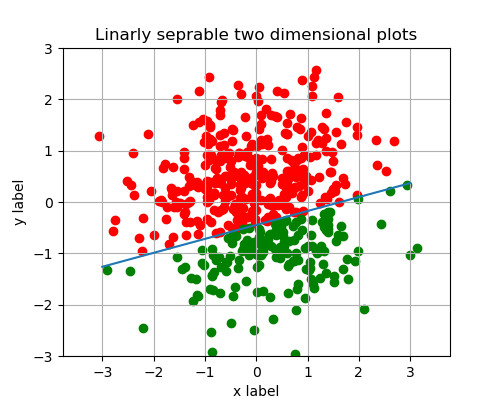

In [66]:
fig, ax = plt.subplots(figsize=(5,4))
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.set_title('Linarly seprable two dimensional plots')

ax.scatter(X[T==0, 1], X[T==0, 2], c='red')
ax.scatter(X[T==1, 1], X[T==1, 2], c='green')

# Hyperplace (X-b)V = 0 -> x1V1 + x2V2 - bV2 = 0
x = np.linspace(-3,3,100)
y = -(V[1] / V[2]) * x - (V[0] / V[2])
ax.plot(x, y)
ax.set_xlim(-3, 3)
ax.set_ylim(-3, 3)
ax.grid()

## Train binary classifiers
1. Sigmoid binary classifier
2. Softmax binary classifier

In [67]:
%matplotlib notebook

def draw_training(X, W, _ax=None, _fig=None, colors=['b']):
    w0 = W[0]
    w1 = W[1]
    w2 = W[2]
    
    #_ax.set_xlim(-3, 3)
    #_ax.set_ylim(-3, 3)
    #_ax.set_title(label=f"W: {W}")

    #_ax.scatter(X[T==0, 1], X[T==0, 2], c='red')
    #_ax.scatter(X[T==1, 1], X[T==1, 2], c='green')
    x = np.linspace(-3,3,100)
    if _ax.lines:
        for line in _ax.lines:
            line.set_xdata(x)
            y = -w1/w2 * x - w0 / w2
            line.set_ydata(y)
    else:
        for color in colors:
            y = -w1/w2 * x - w0 / w2
            _ax.plot(x, y, color)

    fig.canvas.draw()

    _x = np.linspace(-3,3,100)
    _y = -w1/w2 * x - w0 / w2
    _ax.plot(_x, _y, label='linear')  # Plot some data on the _axes.


<IPython.core.display.Javascript object>


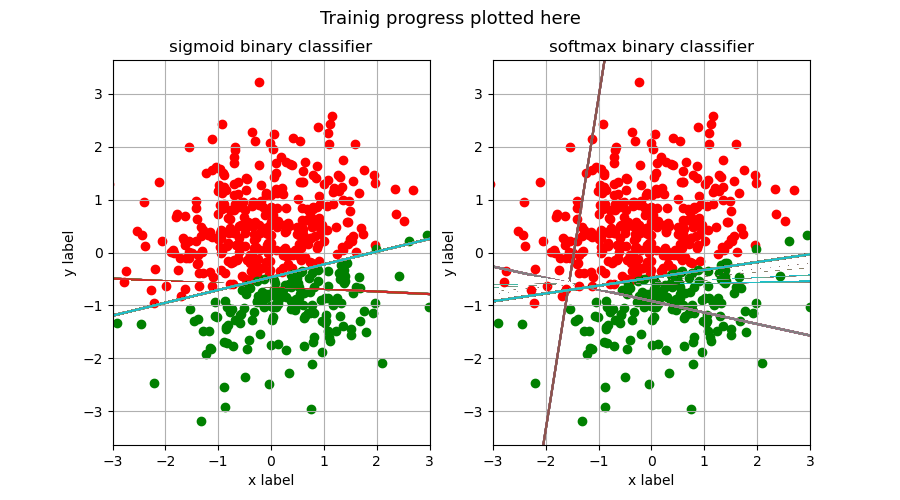

Text(0.5, 1.0, 'softmax binary classifier')

In [68]:
fig, ax = plt.subplots(1, 2, figsize=(9,5))
for i in range(2):
    ax[i].scatter(X[T==0, 1], X[T==0, 2], c='red')
    ax[i].scatter(X[T==1, 1], X[T==1, 2], c='green')
    ax[i].set_xlabel('x label')
    ax[i].set_ylabel('y label')
    ax[i].axis('equal')
    ax[i].set_xlim(-3, 3)
    ax[i].set_ylim(-3, 3)
    ax[i].grid()

fig.suptitle('Trainig progress plotted here', fontsize=13)
ax[0].set_title("sigmoid binary classifier")
ax[1].set_title("softmax binary classifier")

## Sigmoid classifier training

Plots in the previous cell.

In [69]:
print(f"Train a sigmoid classifier to find optimal W {tuple(V)} for the boundary.")
MAX_TEST_TIMES = 100

M = 1
W = weights.xavier(M, D)    # Xavier initialization for Sigmoid
optimizer = SGD(lr=0.1)
draw = partial(draw_training, X=X, _fig=fig, _ax=ax[0])
ax[0].set_xlim(-3, 3)
ax[0].set_ylim(-3, 3)

train_binary_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=sigmoid_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False,
    callback=draw
)

Train a sigmoid classifier to find optimal W (-0.3961203756882132, 0.2407272181139639, -0.8860807268097759) for the boundary.
iteration 0 Loss 0.5424252855866728
iteration 50 Loss 0.3030911075658735


array([[-0.884709  ,  0.45743097, -1.89021919]])

## softmax classifier training
Two class classification with softmax activation. 
Plots in the previous cell.

In [70]:
print(f"Train a softmax classifier to find optimal W {tuple(V)} for the boundary.")
MAX_TEST_TIMES = 200

M = 2                      
W = weights.he(M, D)
optimizer = SGD(lr=0.1)
draw = partial(draw_training, X=X, _fig=fig, _ax=ax[1])
ax[1].set_xlim(-3, 3)
ax[1].set_ylim(-3, 3)

train_binary_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False, 
    callback=draw
)

Train a softmax classifier to find optimal W (-0.3961203756882132, 0.2407272181139639, -0.8860807268097759) for the boundary.
iteration 0 Loss 1.389557717070083
iteration 50 Loss 0.2840722969883198
iteration 100 Loss 0.2022397434846573
iteration 150 Loss 0.16849435557502265


array([[ 0.8694152 , -0.26944904,  1.81695437],
       [-0.5398459 ,  0.6460551 , -1.37828315]])

---

# Categorical Classification

Use Matmul and CrossEntropyLogLoss layers to classify M categorical data.

In [71]:
from common import (
    prediction_grid,
)
from data import (
    linear_separable_sectors,
)
from network import (
    train_matmul_relu_classifier
)

## Linearly separable multiple categories

### Data X and Label T
Training data to linearly classify into M categories and labels T.

In [72]:
print(f"Train a categorical classifier")
N = 300
D = 3      # Dimension
M = 3

rotation = np.radians(35)
# x0 = X[::,0] is the bias 1
X, T, B = linear_separable_sectors(n=N, d=D, m=M, r=2, rotation=rotation)

Train a categorical classifier


#### Plot X, T

<IPython.core.display.Javascript object>


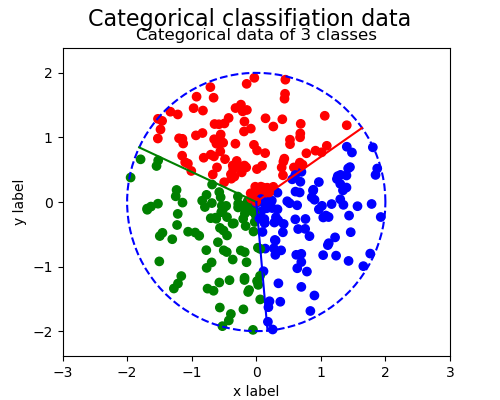

In [73]:
# Radius of a circle within which to place plots.
radius = 2   

# --------------------------------------------------------------------------------
# Plot area
# --------------------------------------------------------------------------------
fig, ax = plt.subplots(figsize=(5,4))
for i in range(2):
    ax.set_xlabel('x label')
    ax.set_ylabel('y label')
    ax.axis('equal')
    ax.set_xlim(-3, 3)
    ax.set_ylim(-3, 3)
    ax.grid()

ax.set_title(f"Categorical data of {M} classes")

# --------------------------------------------------------------------------------
# Cirle within which to place random plots.
# --------------------------------------------------------------------------------
r = np.linspace(0, 2 * np.pi, 100)
ax.plot(radius * np.cos(r), radius * np.sin(r), "b--")

# --------------------------------------------------------------------------------
# Classify plots (x, y) if inside the coverage sector
# labels to classify outside/0/red or inside/1/green.
# --------------------------------------------------------------------------------
Y = COLOR_LABELS[
    T
]

# --------------------------------------------------------------------------------
# Plot color-classified points.
# --------------------------------------------------------------------------------
ax.scatter(X[::,1], X[::,2], marker='o', color=Y)

# --------------------------------------------------------------------------------
# Plot sector bases
# --------------------------------------------------------------------------------
for i in range(B.shape[0]):
    ax.plot((0, radius * B[i, 0]), (0, radius * B[i, 1]), COLOR_LABELS[i])

# ax.legend()
fig.suptitle('Categorical classifiation data', fontsize=16)

plt.draw()
plt.show()


### Train on linearly separable multiple categories

In [74]:
MAX_TEST_TIMES = 1000
W = weights.he(M, D)
optimizer = SGD(lr=0.3)

train_matmul_relu_classifier
# W = train_classifier(
W = train_matmul_relu_classifier(
    N=N,
    D=D,
    M=M,
    X=X,
    T=T,
    W=W,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False
)

Expected dL/dW 
[[ 0.03819927  0.00838697 -0.27427244]
 [ 0.          0.          0.        ]
 [ 0.11798717 -0.15736939  0.09605715]]
Diff
[[ 0.00684242 -0.00584712  0.01726443]
 [ 0.          0.          0.        ]
 [-0.01304374  0.00707045 -0.01147227]]
Expected dL/dW 
[[ 0.03897315 -0.00197257 -0.25299932]
 [ 0.          0.          0.        ]
 [ 0.10653172 -0.1521739   0.08476004]]
Diff
[[ 0.00632943 -0.00479772  0.01542447]
 [ 0.          0.          0.        ]
 [-0.01151227  0.00630729 -0.01020998]]
Expected dL/dW 
[[ 0.04041978 -0.00656205 -0.23047787]
 [ 0.          0.          0.        ]
 [ 0.09432211 -0.14881629  0.07597633]]
Diff
[[ 0.00592615 -0.00398753  0.01298375]
 [ 0.          0.          0.        ]
 [-0.00994741  0.00565914 -0.00891729]]
Expected dL/dW 
[[ 0.03695775 -0.01419645 -0.20903032]
 [ 0.          0.          0.        ]
 [ 0.07923997 -0.15181554  0.06769099]]
Diff
[[ 0.00542686 -0.00337078  0.01100801]
 [ 0.          0.          0.        ]
 [-0.0083898

iteration 0 Loss 1.2106677828036485
iteration 50 Loss 0.7004795830353785
iteration 100 Loss 0.6299263348515535
iteration 150 Loss 0.5963857321823071
iteration 200 Loss 0.5755928134321524
iteration 250 Loss 0.560665997235141
iteration 300 Loss 0.5488290949717458
iteration 350 Loss 0.5395779170123314
iteration 400 Loss 0.531931707999444
iteration 450 Loss 0.5254980416441886
iteration 500 Loss 0.5199752566561354
iteration 550 Loss 0.5152001327727281
iteration 600 Loss 0.5111817757825643
iteration 650 Loss 0.5075546157856278
iteration 700 Loss 0.5042219594591452
iteration 750 Loss 0.5011017249847669
iteration 800 Loss 0.498180964233887
iteration 850 Loss 0.49544749227486257
iteration 900 Loss 0.49292674527885577
iteration 950 Loss 0.4906205824515724


### Run predictions

Run preditions against the grid coordinates (x1, x2).
```
x1: X[:, 1].min() - 1 <= x1 <=  X[:, 1].max() + 1
x2: X[:, 2].min() - 1 <= x2 <=  X[:, 2].max() + 1
grid = np.meshgrid(x1, x2)

# np.argmax(scores) selets the highest score for each data point in X.
# e.g score[i] = [0.2, 8.2, 0.3], then np.argmax(scores[i]) selects index 1 as the prediction. 
# Then cluster of predition/label == 1 will form a contour.
sores = grid @ W.T
predictions = p.argmax(score, axis=1)
```

### Plot predictions

<IPython.core.display.Javascript object>


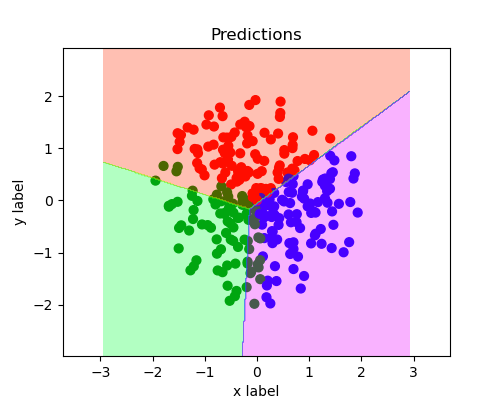

/home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/drawing/functions.py:57: UserWarning: linewidths is ignored by contourf
  axes.contourf(grid[0], grid[1], predictions, cmap=plt.cm.gist_rainbow, alpha=0.3, linewidths=10)


In [75]:
fig, ax = plt.subplots(figsize=(5,4)) 
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()
ax.set_title("Predictions")
#ax.set_xlim(-3, 3)
#ax.set_ylim(-3, 3)

x_grid, y_grid, predictions = prediction_grid(X, W)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

plt.show()

## Non-linearly separable data

In [76]:
from data import (
    set_in_a_radius,
    sets_of_circle_A_not_B
)
from common import (
    prediction_grid_2d
)
from network import (
    train_two_layer_classifier
)

### Data X and Label T
Training data set that cannot be linearly classified. ```X = ((A not B), (B not C), (C not A), (A and B and C and D))``` for circles A, B, C.

<IPython.core.display.Javascript object>


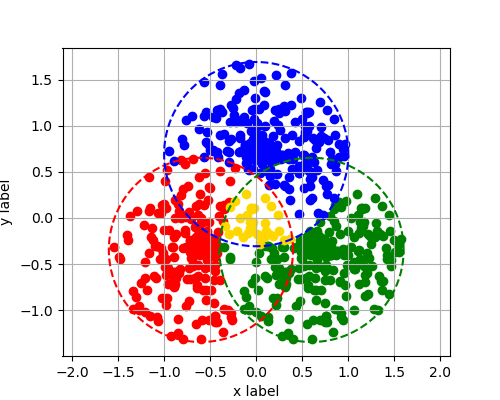

In [79]:
__M = 3        # Number of circles
__N = 300
radius = 1
circles, centres, intersection = sets_of_circle_A_not_B(radius=radius, ratio=1.2, m=__M, n=__N)

fig, ax = plt.subplots(figsize=(5,4)) 
ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()
r = np.linspace(0, 2*np.pi, 100)

# (A not B), (B not C), (C not A)
for i in range(__M):
    circle = circles[i]
    if circle.size > 0:
        x = centres[i][0]
        y = centres[i][1]
        ax.scatter(circle[::, 0], circle[::, 1], color=COLOR_LABELS[i])
        ax.plot(
            x + radius * np.cos(r), 
            y + radius * np.sin(r), 
            linestyle='dashed', 
            color=COLOR_LABELS[i]
        )

# (A and B and C and D)
M = __M + 1
ax.scatter(intersection[::, 0], intersection[::, 1], color='gold')

In [80]:
# Stack all circles and intersect
X = np.vstack(
    [circles[i] for i in range(M-1)] + 
    [intersection]
)

T = np.hstack(
    [np.full(circles[i].shape[0], i) for i in range(M-1)] + 
    [np.full(intersection.shape[0], M-1)]
)
N = T.shape[0]
assert T.shape[0] == X.shape[0]

# Shuffle the data
indices = np.random.permutation(range(T.shape[0]))

X = X[indices]
X = np.c_[
    np.ones(X.shape[0]),
    X
]       # Add bias=1
T = T[indices]
Y = COLOR_LABELS[T]


print(f"X:{X.shape} T:{T.shape} ")

X:(712, 3) T:(712,) 


### Train on non-linear separable spiral data

In [81]:
MAX_TEST_TIMES = 30000
D = 3
M1 = 8
W1 = weights.he(M1, D)
M2: int = M                 # Number of categories to classify
W2 = weights.he(M2, M1)
optimizer = SGD(lr=0.5)

X, T = transform_X_T(X, T)
W1, W2, objective, prediction = train_two_layer_classifier(
    N=N,
    D=D,
    X=X,
    T=T,
    M1=M1,
    W1=W1,
    M2=M2,
    W2=W2,
    log_loss_function=softmax_cross_entropy_log_loss,
    optimizer=optimizer,
    num_epochs=MAX_TEST_TIMES,
    test_numerical_gradient=False
)


Expected dL/dW 
[[ 1.13604273e-02  1.28617226e-02  2.15472920e-01  4.55305436e-03
   3.12576110e-02  6.37688859e-05  1.33609811e-01  3.69010479e-02]
 [-1.26534736e-02  7.04348042e-03 -1.53592259e-01  2.52501574e-03
   3.15502195e-02  2.16067113e-04 -1.05473805e-01  5.96189501e-02]
 [-4.36883041e-03 -2.47553242e-02 -1.73576585e-01 -8.74907721e-03
  -8.70013566e-02 -4.78370831e-04 -1.17478780e-01 -1.97476625e-01]
 [ 5.66187669e-03  4.85012117e-03  1.10227805e-01  1.67100711e-03
   1.74511955e-02  8.01136941e-05  7.86310953e-02  5.45305487e-02]]
Diff
[[-3.05501224e-03 -3.44836095e-03 -6.08286745e-02 -1.28205608e-03
  -1.25316181e-02 -6.80750272e-05 -4.41128790e-02 -4.11473251e-02]
 [ 1.40275579e-03  1.27645964e-03  2.45556946e-02  4.97092501e-04
   3.96454968e-03  1.29128824e-05  1.75343619e-02  1.34929079e-02]
 [ 2.00842635e-03  2.43055067e-03  4.16587851e-02  8.80914060e-04
   8.97946177e-03  5.61616731e-05  3.00331820e-02  2.78900733e-02]
 [-3.56169901e-04 -2.58649370e-04 -6.03081858e-

Expected dL/dW 
[[-0.00553287  0.00064564 -0.01285468]
 [ 0.01617698  0.00439695  0.0180751 ]
 [-0.04086213 -0.11217356  0.00646138]
 [-0.00247927 -0.0009509  -0.00271742]
 [-0.05648169 -0.0480188  -0.10508867]
 [-0.0021178  -0.00015767 -0.00470152]
 [-0.05098162  0.04485152 -0.03274733]
 [-0.05404447  0.10615807  0.01965039]]
Diff
[[ 1.62462177e-04 -1.22720487e-04  7.42628628e-04]
 [-8.60629634e-04 -9.84192704e-05 -1.03154526e-03]
 [-2.54400876e-03 -1.56496249e-02  2.61403927e-03]
 [-2.82877312e-05 -2.13227437e-06 -2.86084842e-05]
 [-1.19858617e-03 -3.42367263e-03 -6.03156629e-03]
 [ 3.20794683e-04 -2.01437893e-04  3.41777555e-04]
 [ 1.06022628e-03 -4.90168755e-03 -1.65711625e-03]
 [-4.00642401e-03  8.26936473e-03 -7.31575178e-03]]
Expected dL/dW 
[[-0.00352496  0.00213593 -0.01220568]
 [ 0.01373736  0.00386417  0.0155382 ]
 [-0.04169557 -0.11919093  0.01276312]
 [-0.00281412 -0.00123782 -0.0029803 ]
 [-0.04461406 -0.04089257 -0.10833914]
 [-0.00256313  0.00018862 -0.00495558]
 [-0.05

Expected dL/dW 
[[ 6.80882056e-04  1.84603686e-04  3.35935267e-02  3.50554357e-04
   2.55225273e-02  3.16775743e-04 -1.84716668e-02 -7.87808199e-02]
 [ 1.35206169e-03  3.71637900e-04 -9.03354347e-02  1.73522968e-03
   5.19212817e-02  2.34691230e-06 -3.04637624e-03  2.12016323e-02]
 [-5.86035156e-03 -8.04348998e-04 -1.29392749e-04 -2.88304348e-03
  -9.93327597e-02 -5.17864477e-04 -1.24268329e-02  2.15219624e-02]
 [ 9.83742003e-04  8.60262102e-05  1.07205560e-02  3.26709341e-04
   4.66276265e-03  0.00000000e+00  4.47071680e-03  1.41208669e-03]]
Diff
[[-2.85562013e-05 -1.09430577e-05 -3.44859442e-05 -1.95921044e-05
   1.00300421e-04  1.49906265e-05  2.98220153e-03  6.85683994e-03]
 [ 4.11470048e-04 -1.85273285e-05  1.12572011e-02 -3.45955712e-05
  -1.93099901e-06 -2.79613854e-07  3.18391835e-03  2.32620401e-04]
 [-7.76507594e-05  5.29812017e-05 -4.94309314e-03  1.21228367e-04
   2.02657381e-03 -4.61292992e-07 -2.28116671e-03 -3.19011578e-03]
 [-8.87179412e-05 -9.08394095e-06 -9.62132224e-

iteration 0 Loss 1.5024483288757322
iteration 100 Loss 0.18875336595907383
iteration 200 Loss 0.163138747127031
iteration 300 Loss 0.15156164057556482
iteration 400 Loss 0.14545476882891517
iteration 500 Loss 0.14160204504963073
iteration 600 Loss 0.1376926751930589
iteration 700 Loss 0.1349632694465617
iteration 800 Loss 0.1328947372088095
iteration 900 Loss 0.13126358667269694
iteration 1000 Loss 0.12995971449431717
iteration 1100 Loss 0.12878542787807748
iteration 1200 Loss 0.12765708963441275
iteration 1300 Loss 0.1265699514079611
iteration 1400 Loss 0.1255375000868014
iteration 1500 Loss 0.12455366506215243
iteration 1600 Loss 0.12360373013656036
iteration 1700 Loss 0.12267708307604382
iteration 1800 Loss 0.12176010814315996
iteration 1900 Loss 0.1208697755963163
iteration 2000 Loss 0.12001023252901237
iteration 2100 Loss 0.11918498454101376
iteration 2200 Loss 0.11840118323384383
iteration 2300 Loss 0.11765280421556927
iteration 2400 Loss 0.11691947577412738
iteration 2500 Loss 0

Iteration [4101]: Loss[0.10755194196558784] has not improved from the previous [0.10755140570010634] for 1 times.


iteration 4100 Loss 0.10755140570010634


Iteration [4221]: Loss[0.10699064897043974] has not improved from the previous [0.10698927272741264] for 1 times.


iteration 4200 Loss 0.1070854555618627


Iteration [4281]: Loss[0.10670677195439131] has not improved from the previous [0.1067064404259851] for 1 times.


iteration 4300 Loss 0.10660914186515846


Iteration [4441]: Loss[0.10594566968920674] has not improved from the previous [0.10594530304190614] for 1 times.


iteration 4400 Loss 0.10613301918854537


Iteration [4461]: Loss[0.1058543391681068] has not improved from the previous [0.1058531780109066] for 1 times.


iteration 4500 Loss 0.10567223628045143


Iteration [4601]: Loss[0.10522218442227702] has not improved from the previous [0.10522039570805428] for 1 times.


iteration 4600 Loss 0.10522039570805428


Iteration [4721]: Loss[0.1047114158768076] has not improved from the previous [0.10471006485307457] for 1 times.


iteration 4700 Loss 0.10479610307948777


Iteration [4801]: Loss[0.10438384859047938] has not improved from the previous [0.104381344580178] for 1 times.
Iteration [4861]: Loss[0.1041409627221335] has not improved from the previous [0.10413853902225315] for 1 times.


iteration 4800 Loss 0.104381344580178
iteration 4900 Loss 0.10398108968285454


Iteration [4961]: Loss[0.103745388584124] has not improved from the previous [0.103743157468885] for 1 times.


iteration 5000 Loss 0.10356774776735814
iteration 5100 Loss 0.10271482191027817
iteration 5200 Loss 0.10204118054513374


Iteration [5361]: Loss[0.1010752680675142] has not improved from the previous [0.10107431054475578] for 1 times.


iteration 5300 Loss 0.10142905720094203
iteration 5400 Loss 0.10085262295137104


Iteration [5521]: Loss[0.10020640829034058] has not improved from the previous [0.10020369451779683] for 1 times.


iteration 5500 Loss 0.10030847662025713
iteration 5600 Loss 0.09985608977954687


Iteration [5681]: Loss[0.099526670817023] has not improved from the previous [0.09952407604222079] for 1 times.


iteration 5700 Loss 0.09944848630352869


Iteration [5741]: Loss[0.09928672919201381] has not improved from the previous [0.09928460756648022] for 1 times.
Iteration [5821]: Loss[0.09897231866670297] has not improved from the previous [0.09897118621007399] for 1 times.


iteration 5800 Loss 0.09905154430853896


Iteration [5841]: Loss[0.09889493710326563] has not improved from the previous [0.09889409732072726] for 1 times.


iteration 5900 Loss 0.09866999464651242
iteration 6000 Loss 0.09829105184655398
iteration 6100 Loss 0.09792634544018966
iteration 6200 Loss 0.0975712390874719


Iteration [6301]: Loss[0.09721905956060659] has not improved from the previous [0.09721794432182626] for 1 times.
Iteration [6321]: Loss[0.09715149636765334] has not improved from the previous [0.0971481640448986] for 1 times.


iteration 6300 Loss 0.09721794432182626
iteration 6400 Loss 0.0968827657084375


Iteration [6461]: Loss[0.09667959887623426] has not improved from the previous [0.09667553338556878] for 1 times.


iteration 6500 Loss 0.09654940715083454


Iteration [6561]: Loss[0.09633962789762554] has not improved from the previous [0.0963384041972948] for 1 times.
Iteration [6621]: Loss[0.09613949512101706] has not improved from the previous [0.09613689674582428] for 1 times.


iteration 6600 Loss 0.09620959109310093


Iteration [6661]: Loss[0.09600637636040264] has not improved from the previous [0.09600609057887446] for 1 times.


iteration 6700 Loss 0.095875967322718


Iteration [6801]: Loss[0.09555725059911237] has not improved from the previous [0.09555715713992056] for 1 times.


iteration 6800 Loss 0.09555715713992056


Iteration [6861]: Loss[0.09537473902685958] has not improved from the previous [0.09537043338527883] for 1 times.


iteration 6900 Loss 0.09525838640367786


Iteration [6961]: Loss[0.0950781558197296] has not improved from the previous [0.09507531296516498] for 1 times.


iteration 7000 Loss 0.09496485750746528


Iteration [7041]: Loss[0.09484685457689598] has not improved from the previous [0.09484597419100015] for 1 times.
Iteration [7101]: Loss[0.09467540906583187] has not improved from the previous [0.09467515441156493] for 1 times.
Iteration [7161]: Loss[0.094505341115926] has not improved from the previous [0.09450519840904979] for 1 times.


iteration 7100 Loss 0.09467515441156493


Iteration [7261]: Loss[0.09422577488772564] has not improved from the previous [0.0942228264777029] for 1 times.


iteration 7200 Loss 0.09439230888043762


Iteration [7321]: Loss[0.09405880102946029] has not improved from the previous [0.09405660511784986] for 1 times.


iteration 7300 Loss 0.09411504828936511


Iteration [7381]: Loss[0.09389259071514149] has not improved from the previous [0.09389195144821226] for 1 times.
Iteration [7421]: Loss[0.09378350005166325] has not improved from the previous [0.09378328852240786] for 1 times.


iteration 7400 Loss 0.09384185840062628
iteration 7500 Loss 0.09357062186068141


Iteration [7621]: Loss[0.09325270278798382] has not improved from the previous [0.09325141741410922] for 1 times.


iteration 7600 Loss 0.09330539272906681


Iteration [7661]: Loss[0.09314916603002404] has not improved from the previous [0.09314677638129276] for 1 times.
Iteration [7721]: Loss[0.0929950306140814] has not improved from the previous [0.09299265126316782] for 1 times.


iteration 7700 Loss 0.09304660181391482


Iteration [7781]: Loss[0.09284293472756995] has not improved from the previous [0.09284042718888641] for 1 times.


iteration 7800 Loss 0.09279402463411066


Iteration [7861]: Loss[0.09264107791764058] has not improved from the previous [0.09264037630152017] for 1 times.
Iteration [7941]: Loss[0.09244659307615558] has not improved from the previous [0.09244396610628895] for 1 times.


iteration 7900 Loss 0.09254670583545738
iteration 8000 Loss 0.0923043882597088


Iteration [8061]: Loss[0.0921610014440534] has not improved from the previous [0.09215973967488635] for 1 times.
Iteration [8081]: Loss[0.09211538130383719] has not improved from the previous [0.09211153054688818] for 1 times.


iteration 8100 Loss 0.09206916401273953


Iteration [8181]: Loss[0.09188251550517726] has not improved from the previous [0.0918798218653379] for 1 times.


iteration 8200 Loss 0.09183578943540156


Iteration [8301]: Loss[0.09160684594680726] has not improved from the previous [0.0916045259621383] for 1 times.


iteration 8300 Loss 0.0916045259621383


Iteration [8401]: Loss[0.0913774778233191] has not improved from the previous [0.09137726871272266] for 1 times.


iteration 8400 Loss 0.09137726871272266


Iteration [8421]: Loss[0.09133282033089397] has not improved from the previous [0.0913312067450851] for 1 times.
Iteration [8481]: Loss[0.09119733464472746] has not improved from the previous [0.09119621265450963] for 1 times.
Iteration [8541]: Loss[0.09106339868205468] has not improved from the previous [0.09106159046808107] for 1 times.


iteration 8500 Loss 0.09115378517337834
iteration 8600 Loss 0.09093069492609329


Iteration [8721]: Loss[0.09066798092280225] has not improved from the previous [0.09066621083308492] for 1 times.


iteration 8700 Loss 0.09071214959140801


Iteration [8821]: Loss[0.0904516150259507] has not improved from the previous [0.09045107743384742] for 1 times.


iteration 8800 Loss 0.09049616216809515


Iteration [8861]: Loss[0.09036740477549911] has not improved from the previous [0.09036442770723736] for 1 times.
Iteration [8921]: Loss[0.09023804199965792] has not improved from the previous [0.09023743481555732] for 1 times.


iteration 8900 Loss 0.09028125435700957


Iteration [9021]: Loss[0.09002730697795878] has not improved from the previous [0.09002675226487734] for 1 times.


iteration 9000 Loss 0.09007377798768046


Iteration [9041]: Loss[0.08998479645467411] has not improved from the previous [0.08998426683967205] for 1 times.
Iteration [9101]: Loss[0.08986059122024477] has not improved from the previous [0.0898601645901763] for 1 times.
Iteration [9121]: Loss[0.08981890459412703] has not improved from the previous [0.08981886878618946] for 1 times.


iteration 9100 Loss 0.0898601645901763


Iteration [9201]: Loss[0.08965390019424328] has not improved from the previous [0.0896517719933817] for 1 times.
Iteration [9221]: Loss[0.08961542973918622] has not improved from the previous [0.0896106303034621] for 1 times.


iteration 9200 Loss 0.0896517719933817


Iteration [9241]: Loss[0.08957224088689164] has not improved from the previous [0.08957101066306235] for 1 times.


iteration 9300 Loss 0.08944933004972246
iteration 9400 Loss 0.08924923272992909


Iteration [9501]: Loss[0.0890436438932326] has not improved from the previous [0.08904303780792187] for 1 times.
Iteration [9541]: Loss[0.08896419473258713] has not improved from the previous [0.08896252506755832] for 1 times.


iteration 9500 Loss 0.08904303780792187


Iteration [9661]: Loss[0.08872677580573757] has not improved from the previous [0.08872428776741684] for 1 times.


iteration 9600 Loss 0.08884646080370236


Iteration [9681]: Loss[0.08868339356838399] has not improved from the previous [0.08868338614569204] for 1 times.
Iteration [9721]: Loss[0.08859342090737327] has not improved from the previous [0.08859306452788218] for 1 times.


iteration 9700 Loss 0.08863872089016157


Iteration [9741]: Loss[0.08854968913001487] has not improved from the previous [0.08854880736633401] for 1 times.
Iteration [9821]: Loss[0.0883796145494003] has not improved from the previous [0.08837781240123405] for 1 times.


iteration 9800 Loss 0.08842328318690952
iteration 9900 Loss 0.08821423466163454


Iteration [9981]: Loss[0.08804689264147894] has not improved from the previous [0.08804661637505667] for 1 times.
Iteration [10001]: Loss[0.08800606391854772] has not improved from the previous [0.08800513367603717] for 1 times.


iteration 10000 Loss 0.08800513367603717


Iteration [10061]: Loss[0.08788400589698997] has not improved from the previous [0.08788381548553044] for 1 times.


iteration 10100 Loss 0.08780487713042066


Iteration [10161]: Loss[0.08768467595716505] has not improved from the previous [0.08768349327812867] for 1 times.


iteration 10200 Loss 0.0876065973205102


Iteration [10261]: Loss[0.08748714427553042] has not improved from the previous [0.08748594808621116] for 1 times.


iteration 10300 Loss 0.08741008867159578


Iteration [10361]: Loss[0.08729139732047146] has not improved from the previous [0.08729134069751214] for 1 times.
Iteration [10421]: Loss[0.08717467160492254] has not improved from the previous [0.08717415745778911] for 1 times.


iteration 10400 Loss 0.0872148460438584


Iteration [10461]: Loss[0.08709818302410195] has not improved from the previous [0.08709730461698288] for 1 times.
Iteration [10501]: Loss[0.08702058929541197] has not improved from the previous [0.08702012661872302] for 1 times.


iteration 10500 Loss 0.08702012661872302
iteration 10600 Loss 0.08682863803481924


Iteration [10701]: Loss[0.08663844183172191] has not improved from the previous [0.08663841695659508] for 1 times.


iteration 10700 Loss 0.08663841695659508


Iteration [10821]: Loss[0.08641114873575664] has not improved from the previous [0.08641086213359] for 1 times.


iteration 10800 Loss 0.0864514652318231
iteration 10900 Loss 0.08626383483521768
iteration 11000 Loss 0.08607820438492324


Iteration [11081]: Loss[0.08592863843143876] has not improved from the previous [0.08592815433055571] for 1 times.


iteration 11100 Loss 0.08589454568978835
iteration 11200 Loss 0.08539414462424945
iteration 11300 Loss 0.08399104026217429
iteration 11400 Loss 0.08335971790124695
iteration 11500 Loss 0.08289685301444008
iteration 11600 Loss 0.08250427014717313
iteration 11700 Loss 0.08214577310441099


Iteration [11821]: Loss[0.08175215124589764] has not improved from the previous [0.081751760819873] for 1 times.


iteration 11800 Loss 0.08181722472434237
iteration 11900 Loss 0.08150756401862184
iteration 12000 Loss 0.08121571787788949


Iteration [12121]: Loss[0.0808826515952415] has not improved from the previous [0.0808823228352605] for 1 times.
Iteration [12141]: Loss[0.08082939244329644] has not improved from the previous [0.08082861798275937] for 1 times.


iteration 12100 Loss 0.08093767552452627
iteration 12200 Loss 0.08067428194191953


Iteration [12321]: Loss[0.08037007410781528] has not improved from the previous [0.08036989199699128] for 1 times.


iteration 12300 Loss 0.08042215724394128
iteration 12400 Loss 0.08017859872759883
iteration 12500 Loss 0.07994686972538799
iteration 12600 Loss 0.07972198934026535
iteration 12700 Loss 0.0795055045039818
iteration 12800 Loss 0.07929278678107916
iteration 12900 Loss 0.0790861647029276


Iteration [13001]: Loss[0.07888285064029903] has not improved from the previous [0.07888279371530628] for 1 times.


iteration 13000 Loss 0.07888279371530628


Iteration [13121]: Loss[0.0786477711817936] has not improved from the previous [0.07864676152967226] for 1 times.


iteration 13100 Loss 0.07868656007131745


Iteration [13221]: Loss[0.0784569242634395] has not improved from the previous [0.0784564573715991] for 1 times.


iteration 13200 Loss 0.07849524337147565


Iteration [13341]: Loss[0.07823487129829523] has not improved from the previous [0.07823474916271314] for 1 times.


iteration 13300 Loss 0.07830900092360102


Iteration [13381]: Loss[0.07816370777940938] has not improved from the previous [0.0781619478486652] for 1 times.


iteration 13400 Loss 0.07812767674050472
iteration 13500 Loss 0.07794947283143491


Iteration [13661]: Loss[0.07767550480859602] has not improved from the previous [0.07767249805855408] for 1 times.


iteration 13600 Loss 0.07777600973648245
iteration 13700 Loss 0.0776079860070468
iteration 13800 Loss 0.07744198272990292
iteration 13900 Loss 0.07728016046849302


Iteration [14001]: Loss[0.07712287394442222] has not improved from the previous [0.07712220815818116] for 1 times.


iteration 14000 Loss 0.07712220815818116


Iteration [14041]: Loss[0.0770593270093887] has not improved from the previous [0.07705926303058243] for 1 times.
Iteration [14121]: Loss[0.07693653446825509] has not improved from the previous [0.07693642853118186] for 1 times.


iteration 14100 Loss 0.07696770431951241


Iteration [14221]: Loss[0.07678640672398168] has not improved from the previous [0.07678547766326117] for 1 times.


iteration 14200 Loss 0.0768168552228104


Iteration [14261]: Loss[0.07672755761026417] has not improved from the previous [0.07672746240739946] for 1 times.


iteration 14300 Loss 0.07666913770539102


Iteration [14361]: Loss[0.07658037632491842] has not improved from the previous [0.07657987641431854] for 1 times.


iteration 14400 Loss 0.07652308981758749
iteration 14500 Loss 0.07638031387864706
iteration 14600 Loss 0.0762419663138247
iteration 14700 Loss 0.07610467876245737


Iteration [14781]: Loss[0.07599675788940576] has not improved from the previous [0.07599469385494603] for 1 times.


iteration 14800 Loss 0.07596985410728042


Iteration [14861]: Loss[0.07589064166288319] has not improved from the previous [0.07588912203950776] for 1 times.
Iteration [14921]: Loss[0.07581235618436195] has not improved from the previous [0.07581147577891607] for 1 times.


iteration 14900 Loss 0.07583888039789141


Iteration [14981]: Loss[0.07573504392966458] has not improved from the previous [0.07573318594016139] for 1 times.


iteration 15000 Loss 0.07570775637058931


Iteration [15101]: Loss[0.07558206470227251] has not improved from the previous [0.07558088957543001] for 1 times.


iteration 15100 Loss 0.07558088957543001


Iteration [15161]: Loss[0.07550597423938255] has not improved from the previous [0.07550539039732271] for 1 times.
Iteration [15201]: Loss[0.07545580976607913] has not improved from the previous [0.07545550901334969] for 1 times.
Iteration [15221]: Loss[0.07543166737530461] has not improved from the previous [0.07543141812943033] for 1 times.


iteration 15200 Loss 0.07545550901334969
iteration 15300 Loss 0.07533410129998543


Iteration [15321]: Loss[0.07531075003749604] has not improved from the previous [0.07530874605428935] for 1 times.


iteration 15400 Loss 0.07521300316332093


Iteration [15461]: Loss[0.07514208421323954] has not improved from the previous [0.07514182066875542] for 1 times.


iteration 15500 Loss 0.07509471474667366


Iteration [15581]: Loss[0.07500300743180752] has not improved from the previous [0.07500221080642834] for 1 times.


iteration 15600 Loss 0.07497969896475537


Iteration [15621]: Loss[0.07495554865119577] has not improved from the previous [0.07495523992810073] for 1 times.
Iteration [15681]: Loss[0.07488778310717818] has not improved from the previous [0.07488688175082038] for 1 times.


iteration 15700 Loss 0.07486456510386154


Iteration [15761]: Loss[0.07479835226887625] has not improved from the previous [0.0747961859077317] for 1 times.


iteration 15800 Loss 0.07475396218284057


Iteration [15861]: Loss[0.07468654008991026] has not improved from the previous [0.07468635151293188] for 1 times.
Iteration [15901]: Loss[0.07464222383065856] has not improved from the previous [0.07464210509947135] for 1 times.


iteration 15900 Loss 0.07464210509947135


Iteration [15941]: Loss[0.07459882350515355] has not improved from the previous [0.07459796075646694] for 1 times.
Iteration [15961]: Loss[0.07457751080963197] has not improved from the previous [0.07457678659730375] for 1 times.
Iteration [16001]: Loss[0.07453477683581486] has not improved from the previous [0.0745336799372738] for 1 times.


iteration 16000 Loss 0.0745336799372738
iteration 16100 Loss 0.07442845386758512


Iteration [16141]: Loss[0.07438598715566533] has not improved from the previous [0.07438457335087022] for 1 times.
Iteration [16161]: Loss[0.07436568600545497] has not improved from the previous [0.0743645702742324] for 1 times.


iteration 16200 Loss 0.07432434343117528


Iteration [16281]: Loss[0.0742408144368572] has not improved from the previous [0.0742399326198683] for 1 times.


iteration 16300 Loss 0.074220385738406
iteration 16400 Loss 0.07412005356239507


Iteration [16461]: Loss[0.07405904215394235] has not improved from the previous [0.07405902194960548] for 1 times.


iteration 16500 Loss 0.07401977783658541


Iteration [16521]: Loss[0.07399973728995077] has not improved from the previous [0.0739983825295988] for 1 times.


iteration 16600 Loss 0.07392193152498983


Iteration [16661]: Loss[0.07386383684659954] has not improved from the previous [0.07386277803610557] for 1 times.


iteration 16700 Loss 0.07382504169569862


Iteration [16781]: Loss[0.07374920138251978] has not improved from the previous [0.07374912046100973] for 1 times.
Iteration [16801]: Loss[0.07373063216756302] has not improved from the previous [0.07372896254564643] for 1 times.


iteration 16800 Loss 0.07372896254564643


Iteration [16821]: Loss[0.07371088041494102] has not improved from the previous [0.07371075944023864] for 1 times.
Iteration [16881]: Loss[0.07365518511372057] has not improved from the previous [0.07365513641392392] for 1 times.
Iteration [16901]: Loss[0.07363761056429192] has not improved from the previous [0.07363602192973309] for 1 times.


iteration 16900 Loss 0.07363602192973309
iteration 17000 Loss 0.07354565647704006
iteration 17100 Loss 0.07345718564529892


Iteration [17141]: Loss[0.0734210199782169] has not improved from the previous [0.0734194454107262] for 1 times.
Iteration [17161]: Loss[0.07340336793886236] has not improved from the previous [0.07340334506857586] for 1 times.
Iteration [17181]: Loss[0.07338511192287324] has not improved from the previous [0.07338463154208488] for 1 times.


iteration 17200 Loss 0.073367942425485


Iteration [17221]: Loss[0.07335000860452526] has not improved from the previous [0.07334914524031551] for 1 times.


iteration 17300 Loss 0.07328352207584903


Iteration [17361]: Loss[0.07323154614391322] has not improved from the previous [0.07323124798117679] for 1 times.


iteration 17400 Loss 0.07319753427562517


Iteration [17441]: Loss[0.07316452444698177] has not improved from the previous [0.07316356986799602] for 1 times.
Iteration [17461]: Loss[0.07314688052418547] has not improved from the previous [0.0731460337741361] for 1 times.
Iteration [17481]: Loss[0.07312968236167301] has not improved from the previous [0.07312919760082479] for 1 times.
Iteration [17501]: Loss[0.0731145261083436] has not improved from the previous [0.07311289949124254] for 1 times.


iteration 17500 Loss 0.07311289949124254


Iteration [17521]: Loss[0.07309680137910572] has not improved from the previous [0.0730966091417366] for 1 times.
Iteration [17541]: Loss[0.0730820376547994] has not improved from the previous [0.07308010709709584] for 1 times.
Iteration [17601]: Loss[0.07303255978619244] has not improved from the previous [0.07303178710564018] for 1 times.


iteration 17600 Loss 0.07303178710564018
iteration 17700 Loss 0.07295193557958177


Iteration [17741]: Loss[0.07291985682320028] has not improved from the previous [0.07291849867147066] for 1 times.
Iteration [17801]: Loss[0.07287172489571729] has not improved from the previous [0.07287149661272567] for 1 times.


iteration 17800 Loss 0.07287149661272567
iteration 17900 Loss 0.0727962449619322


Iteration [17961]: Loss[0.07274846995338932] has not improved from the previous [0.07274772866849989] for 1 times.
Iteration [18001]: Loss[0.07271869765036817] has not improved from the previous [0.0727178115032913] for 1 times.


iteration 18000 Loss 0.0727178115032913
iteration 18100 Loss 0.07264453832065174


Iteration [18121]: Loss[0.07262944057901694] has not improved from the previous [0.07262735710371071] for 1 times.


iteration 18200 Loss 0.0725698759618098


Iteration [18301]: Loss[0.07249788551182956] has not improved from the previous [0.07249472056961812] for 1 times.


iteration 18300 Loss 0.07249472056961812


Iteration [18341]: Loss[0.07246663103161038] has not improved from the previous [0.07246644904591049] for 1 times.


iteration 18400 Loss 0.07242445489451527


Iteration [18421]: Loss[0.07241153931367689] has not improved from the previous [0.07240993200195356] for 1 times.
Iteration [18441]: Loss[0.0723958177941092] has not improved from the previous [0.0723944776764393] for 1 times.


iteration 18500 Loss 0.07235428166709396
iteration 18600 Loss 0.07228667491200114


Iteration [18681]: Loss[0.07223261609947426] has not improved from the previous [0.0722305154753464] for 1 times.


iteration 18700 Loss 0.07221842277521644


Iteration [18741]: Loss[0.07219548080564353] has not improved from the previous [0.07219214444259604] for 1 times.


iteration 18800 Loss 0.07215649398064078
iteration 18900 Loss 0.07209215742758691
iteration 19000 Loss 0.07203020337042478


Iteration [19041]: Loss[0.07200693120958865] has not improved from the previous [0.07200479320465356] for 1 times.
Iteration [19061]: Loss[0.07199482324032702] has not improved from the previous [0.07199342584369588] for 1 times.


iteration 19100 Loss 0.07197191424370228


Iteration [19141]: Loss[0.07194641637713885] has not improved from the previous [0.07194559660863399] for 1 times.
Iteration [19161]: Loss[0.07193470271867018] has not improved from the previous [0.07193363636179916] for 1 times.
Iteration [19201]: Loss[0.07191310976044002] has not improved from the previous [0.07190954882967175] for 1 times.


iteration 19200 Loss 0.07190954882967175


Iteration [19221]: Loss[0.07190089164377987] has not improved from the previous [0.07189994754567085] for 1 times.
Iteration [19281]: Loss[0.07186582946833452] has not improved from the previous [0.07186476654061265] for 1 times.


iteration 19300 Loss 0.07185521114848543


Iteration [19381]: Loss[0.07180949569196693] has not improved from the previous [0.07180887559630628] for 1 times.


iteration 19400 Loss 0.07179852027493684


Iteration [19441]: Loss[0.07177713490541306] has not improved from the previous [0.07177488591070195] for 1 times.
Iteration [19481]: Loss[0.07175315131907156] has not improved from the previous [0.07175257980170618] for 1 times.


iteration 19500 Loss 0.07174442130558156


Iteration [19581]: Loss[0.07170005002414363] has not improved from the previous [0.07169995196859924] for 1 times.


iteration 19600 Loss 0.07169288123798653


Iteration [19641]: Loss[0.07166900604355521] has not improved from the previous [0.07166791282241804] for 1 times.
Iteration [19661]: Loss[0.07165912630727059] has not improved from the previous [0.07165791285547636] for 1 times.


iteration 19700 Loss 0.07163830608610758


Iteration [19761]: Loss[0.07160687504707068] has not improved from the previous [0.07160419492147989] for 1 times.
Iteration [19801]: Loss[0.07158616962848323] has not improved from the previous [0.07158544634961976] for 1 times.


iteration 19800 Loss 0.07158544634961976


Iteration [19841]: Loss[0.07156592903810219] has not improved from the previous [0.07156457101032877] for 1 times.
Iteration [19861]: Loss[0.07155655622273731] has not improved from the previous [0.07155635081622157] for 1 times.


iteration 19900 Loss 0.07153703409484072
iteration 20000 Loss 0.07148662630964936


Iteration [20041]: Loss[0.07146784329829207] has not improved from the previous [0.07146581644720801] for 1 times.
Iteration [20101]: Loss[0.07143970248708832] has not improved from the previous [0.07143686068088044] for 1 times.


iteration 20100 Loss 0.07143686068088044


Iteration [20141]: Loss[0.07141903736879258] has not improved from the previous [0.07141835963189645] for 1 times.


iteration 20200 Loss 0.07139186010252667


Iteration [20221]: Loss[0.07138265606762317] has not improved from the previous [0.07138013833916737] for 1 times.
Iteration [20241]: Loss[0.07137291487326203] has not improved from the previous [0.0713715948825661] for 1 times.


iteration 20300 Loss 0.07134446706138727


Iteration [20321]: Loss[0.0713359808994062] has not improved from the previous [0.07133424494493018] for 1 times.
Iteration [20341]: Loss[0.07132684459636059] has not improved from the previous [0.07132449173596273] for 1 times.
Iteration [20401]: Loss[0.07129869321923707] has not improved from the previous [0.07129822924345913] for 1 times.


iteration 20400 Loss 0.07129822924345913


Iteration [20461]: Loss[0.07127243224062735] has not improved from the previous [0.0712702635941017] for 1 times.


iteration 20500 Loss 0.07125336127711454


Iteration [20521]: Loss[0.07124366854765414] has not improved from the previous [0.07124335670378461] for 1 times.
Iteration [20561]: Loss[0.07122785393208134] has not improved from the previous [0.07122575336060841] for 1 times.


iteration 20600 Loss 0.07120902865719143


Iteration [20621]: Loss[0.07119938772254841] has not improved from the previous [0.07119932522609002] for 1 times.
Iteration [20641]: Loss[0.07119081314586585] has not improved from the previous [0.07119080623576542] for 1 times.


iteration 20700 Loss 0.07116534862987424


Iteration [20741]: Loss[0.07114766098320494] has not improved from the previous [0.07114634304815454] for 1 times.
Iteration [20761]: Loss[0.07113876607210712] has not improved from the previous [0.07113801767222712] for 1 times.


iteration 20800 Loss 0.07112203429583941


Iteration [20861]: Loss[0.0710961304476517] has not improved from the previous [0.07109412499342381] for 1 times.
Iteration [20901]: Loss[0.07107842424577458] has not improved from the previous [0.07107750793481936] for 1 times.


iteration 20900 Loss 0.07107750793481936


Iteration [20921]: Loss[0.0710703517141378] has not improved from the previous [0.07106846482625953] for 1 times.
Iteration [20941]: Loss[0.07106124896553391] has not improved from the previous [0.07106023520717823] for 1 times.
Iteration [20981]: Loss[0.071043608560573] has not improved from the previous [0.07104324801308347] for 1 times.


iteration 21000 Loss 0.07103481244511231


Iteration [21041]: Loss[0.07101816291302522] has not improved from the previous [0.0710178483360536] for 1 times.


iteration 21100 Loss 0.07099363065317066


Iteration [21161]: Loss[0.07096878745001652] has not improved from the previous [0.07096762283374589] for 1 times.


iteration 21200 Loss 0.07095184479898123


Iteration [21221]: Loss[0.07094460274160708] has not improved from the previous [0.07094195725720792] for 1 times.
Iteration [21261]: Loss[0.07092718948362006] has not improved from the previous [0.07092640414097713] for 1 times.
Iteration [21281]: Loss[0.07091901503069041] has not improved from the previous [0.07091792147607111] for 1 times.
Iteration [21301]: Loss[0.07091075116693536] has not improved from the previous [0.07091003612115566] for 1 times.


iteration 21300 Loss 0.07091003612115566


Iteration [21321]: Loss[0.07090195290980825] has not improved from the previous [0.07090178293998378] for 1 times.
Iteration [21341]: Loss[0.07089439022466827] has not improved from the previous [0.07089340918395771] for 1 times.
Iteration [21361]: Loss[0.07088573703067112] has not improved from the previous [0.07088542482913114] for 1 times.
Iteration [21381]: Loss[0.07087976600971216] has not improved from the previous [0.0708767095880727] for 1 times.


iteration 21400 Loss 0.07087006959701832


Iteration [21421]: Loss[0.07086156298096397] has not improved from the previous [0.07086049730843749] for 1 times.
Iteration [21441]: Loss[0.07085439763618939] has not improved from the previous [0.07085317543848009] for 1 times.
Iteration [21501]: Loss[0.0708294696172196] has not improved from the previous [0.07082898357288193] for 1 times.


iteration 21500 Loss 0.07082898357288193


Iteration [21601]: Loss[0.0707908414770021] has not improved from the previous [0.07078828187817153] for 1 times.


iteration 21600 Loss 0.07078828187817153


Iteration [21621]: Loss[0.07078290304217873] has not improved from the previous [0.07078057942199832] for 1 times.
Iteration [21641]: Loss[0.07077412197673275] has not improved from the previous [0.0707739115455957] for 1 times.


iteration 21700 Loss 0.07075153092447312
iteration 21800 Loss 0.07071313697433158


Iteration [21821]: Loss[0.07070377148820976] has not improved from the previous [0.07070321386121962] for 1 times.
Iteration [21841]: Loss[0.07069620100775159] has not improved from the previous [0.07069492123763711] for 1 times.
Iteration [21861]: Loss[0.07068833498031306] has not improved from the previous [0.0706881452574962] for 1 times.
Iteration [21901]: Loss[0.07067247249123368] has not improved from the previous [0.0706722886440994] for 1 times.


iteration 21900 Loss 0.0706722886440994


Iteration [21961]: Loss[0.07064983181457035] has not improved from the previous [0.07064910281670501] for 1 times.


iteration 22000 Loss 0.07063579458179832


Iteration [22021]: Loss[0.07062794655513512] has not improved from the previous [0.07062613225277294] for 1 times.
Iteration [22041]: Loss[0.07061863013310157] has not improved from the previous [0.07061817762297155] for 1 times.
Iteration [22081]: Loss[0.07060553535051212] has not improved from the previous [0.07060327865377244] for 1 times.


iteration 22100 Loss 0.07059614140195374


Iteration [22141]: Loss[0.07058132689807592] has not improved from the previous [0.07058131312635757] for 1 times.
Iteration [22201]: Loss[0.0705602267096281] has not improved from the previous [0.07055843634500246] for 1 times.


iteration 22200 Loss 0.07055843634500246


Iteration [22241]: Loss[0.0705456908973015] has not improved from the previous [0.07054309369551062] for 1 times.


iteration 22300 Loss 0.07052220208610589


Iteration [22341]: Loss[0.07050693961283405] has not improved from the previous [0.07050605268949904] for 1 times.


iteration 22400 Loss 0.07048524547005938


Iteration [22421]: Loss[0.07047959088897764] has not improved from the previous [0.07047702867843561] for 1 times.
Iteration [22461]: Loss[0.07046347457146789] has not improved from the previous [0.07046323203883013] for 1 times.
Iteration [22501]: Loss[0.07044822518612516] has not improved from the previous [0.07044803457261982] for 1 times.


iteration 22500 Loss 0.07044803457261982


Iteration [22541]: Loss[0.07043610793031335] has not improved from the previous [0.07043329420030613] for 1 times.


iteration 22600 Loss 0.0704134184312929


Iteration [22641]: Loss[0.07039899281196012] has not improved from the previous [0.07039774837066716] for 1 times.


iteration 22700 Loss 0.0703786021370124


Iteration [22721]: Loss[0.07036988905524806] has not improved from the previous [0.07036986230287368] for 1 times.
Iteration [22781]: Loss[0.07034962997965832] has not improved from the previous [0.07034873181931896] for 1 times.


iteration 22800 Loss 0.07034479903956367


Iteration [22821]: Loss[0.07033547757596323] has not improved from the previous [0.07033518139957809] for 1 times.
Iteration [22861]: Loss[0.07032121876648252] has not improved from the previous [0.07032112360096189] for 1 times.


iteration 22900 Loss 0.07030733772608924


Iteration [22901]: Loss[0.07030753306895687] has not improved from the previous [0.07030733772608924] for 1 times.
Iteration [22961]: Loss[0.07028741461912519] has not improved from the previous [0.07028685530142721] for 1 times.
Iteration [23001]: Loss[0.07027536089745096] has not improved from the previous [0.07027335198863725] for 1 times.


iteration 23000 Loss 0.07027335198863725


Iteration [23041]: Loss[0.0702628682280714] has not improved from the previous [0.07025953772592644] for 1 times.
Iteration [23081]: Loss[0.07024678768488721] has not improved from the previous [0.07024637023048363] for 1 times.


iteration 23100 Loss 0.07023997765008871


Iteration [23181]: Loss[0.07021357683385003] has not improved from the previous [0.07021321698942026] for 1 times.
Iteration [23201]: Loss[0.07020749727192395] has not improved from the previous [0.07020625173258734] for 1 times.


iteration 23200 Loss 0.07020625173258734


Iteration [23301]: Loss[0.07017433040828819] has not improved from the previous [0.07017395868150868] for 1 times.


iteration 23300 Loss 0.07017395868150868


Iteration [23321]: Loss[0.07016759652820342] has not improved from the previous [0.07016740746596065] for 1 times.
Iteration [23361]: Loss[0.07015665170271161] has not improved from the previous [0.07015445992585759] for 1 times.


iteration 23400 Loss 0.07014289199029301


Iteration [23441]: Loss[0.07012872659063296] has not improved from the previous [0.07012811071525875] for 1 times.
Iteration [23461]: Loss[0.07012437581730518] has not improved from the previous [0.07012176314600263] for 1 times.
Iteration [23521]: Loss[0.07010411340368122] has not improved from the previous [0.07010224231465705] for 1 times.


iteration 23500 Loss 0.07010930917773076


Iteration [23561]: Loss[0.07009113400703332] has not improved from the previous [0.07009076953997834] for 1 times.
Iteration [23581]: Loss[0.07008512475203318] has not improved from the previous [0.07008495527136091] for 1 times.
Iteration [23661]: Loss[0.0700604065602408] has not improved from the previous [0.07005895990373064] for 1 times.


iteration 23600 Loss 0.07007872615153547


Iteration [23681]: Loss[0.0700539553376809] has not improved from the previous [0.07005362107033183] for 1 times.


iteration 23700 Loss 0.07004695837068146


Iteration [23721]: Loss[0.07004008837375196] has not improved from the previous [0.07003975255811964] for 1 times.
Iteration [23741]: Loss[0.07003552129342028] has not improved from the previous [0.07003412854158475] for 1 times.
Iteration [23821]: Loss[0.0700100986455567] has not improved from the previous [0.07000927325258523] for 1 times.


iteration 23800 Loss 0.07001674098087271


Iteration [23841]: Loss[0.07000383592435687] has not improved from the previous [0.07000381064993956] for 1 times.
Iteration [23861]: Loss[0.06999817630676046] has not improved from the previous [0.06999749485668776] for 1 times.


iteration 23900 Loss 0.06998752701402643


Iteration [23941]: Loss[0.06997390016269113] has not improved from the previous [0.06997321162579366] for 1 times.
Iteration [23961]: Loss[0.06996708766757065] has not improved from the previous [0.06996671445127835] for 1 times.
Iteration [24001]: Loss[0.06995558235950208] has not improved from the previous [0.06995541568734838] for 1 times.


iteration 24000 Loss 0.06995541568734838


Iteration [24141]: Loss[0.06991467423979436] has not improved from the previous [0.06991285495035716] for 1 times.


iteration 24100 Loss 0.06992639055043134


Iteration [24201]: Loss[0.06989612183519166] has not improved from the previous [0.06989509272044449] for 1 times.
Iteration [24241]: Loss[0.06988404471956258] has not improved from the previous [0.06988307500190737] for 1 times.


iteration 24200 Loss 0.06989509272044449


Iteration [24281]: Loss[0.06987270178000402] has not improved from the previous [0.06987198964675448] for 1 times.


iteration 24300 Loss 0.06986830789282514


Iteration [24401]: Loss[0.06983785412721843] has not improved from the previous [0.06983742434044016] for 1 times.


iteration 24400 Loss 0.06983742434044016


Iteration [24501]: Loss[0.0698101564328629] has not improved from the previous [0.06980917339097496] for 1 times.


iteration 24500 Loss 0.06980917339097496


Iteration [24521]: Loss[0.06980423012730937] has not improved from the previous [0.06980383422814013] for 1 times.
Iteration [24541]: Loss[0.0697983068035317] has not improved from the previous [0.06979814485631948] for 1 times.


iteration 24600 Loss 0.06978349409140723


Iteration [24641]: Loss[0.06976943493922262] has not improved from the previous [0.06976894995636714] for 1 times.
Iteration [24681]: Loss[0.06975871852179326] has not improved from the previous [0.06975802876689202] for 1 times.


iteration 24700 Loss 0.06975338785382017


Iteration [24721]: Loss[0.06974695524957396] has not improved from the previous [0.06974608362570626] for 1 times.
Iteration [24741]: Loss[0.06974183433864284] has not improved from the previous [0.06974075362600264] for 1 times.
Iteration [24761]: Loss[0.06973587061554219] has not improved from the previous [0.06973564863514498] for 1 times.
Iteration [24821]: Loss[0.06972058336506506] has not improved from the previous [0.06971896992639094] for 1 times.


iteration 24800 Loss 0.0697255595511433


Iteration [24881]: Loss[0.06970110532984677] has not improved from the previous [0.06970087954541641] for 1 times.
Iteration [24901]: Loss[0.0696967016770517] has not improved from the previous [0.06969641628423322] for 1 times.


iteration 24900 Loss 0.06969641628423322


Iteration [24941]: Loss[0.0696853137975945] has not improved from the previous [0.06968479234790961] for 1 times.
Iteration [25001]: Loss[0.0696704886640209] has not improved from the previous [0.06966982835839554] for 1 times.


iteration 25000 Loss 0.06966982835839554


Iteration [25061]: Loss[0.06965181759589725] has not improved from the previous [0.06965136122058195] for 1 times.
Iteration [25101]: Loss[0.06964321397417668] has not improved from the previous [0.06964039093956186] for 1 times.


iteration 25100 Loss 0.06964039093956186


Iteration [25161]: Loss[0.06962534062231038] has not improved from the previous [0.06962422326492682] for 1 times.
Iteration [25181]: Loss[0.06961969328820862] has not improved from the previous [0.06961845932399731] for 1 times.


iteration 25200 Loss 0.06961565945325573


Iteration [25221]: Loss[0.0696104641371273] has not improved from the previous [0.06960932986111269] for 1 times.
Iteration [25281]: Loss[0.06959304502617172] has not improved from the previous [0.06959244228766512] for 1 times.
Iteration [25301]: Loss[0.06958688963909912] has not improved from the previous [0.06958552131430616] for 1 times.


iteration 25300 Loss 0.06958552131430616


Iteration [25401]: Loss[0.06956156104483488] has not improved from the previous [0.0695610065510484] for 1 times.


iteration 25400 Loss 0.0695610065510484


Iteration [25541]: Loss[0.06952369754265977] has not improved from the previous [0.06952169383137624] for 1 times.


iteration 25500 Loss 0.06953623860512556
iteration 25600 Loss 0.06950702413118934


Iteration [25681]: Loss[0.06948670261398307] has not improved from the previous [0.06948606672078048] for 1 times.
Iteration [25721]: Loss[0.06947927932575049] has not improved from the previous [0.06947512253484898] for 1 times.


iteration 25700 Loss 0.06948195843193437


Iteration [25761]: Loss[0.06946537757347619] has not improved from the previous [0.06946436548781802] for 1 times.
Iteration [25801]: Loss[0.06945522026784802] has not improved from the previous [0.06945508777673895] for 1 times.


iteration 25800 Loss 0.06945508777673895


Iteration [25861]: Loss[0.06943978924921179] has not improved from the previous [0.06943975104257671] for 1 times.
Iteration [25881]: Loss[0.06943489391486701] has not improved from the previous [0.06943284633614165] for 1 times.


iteration 25900 Loss 0.069430789247073


Iteration [25941]: Loss[0.06941863147935279] has not improved from the previous [0.06941849993187836] for 1 times.
Iteration [25961]: Loss[0.06941603244441424] has not improved from the previous [0.06941440344634628] for 1 times.
Iteration [25981]: Loss[0.06940911062197222] has not improved from the previous [0.0694087119439675] for 1 times.
Iteration [26001]: Loss[0.06940480410102062] has not improved from the previous [0.06940333048057214] for 1 times.


iteration 26000 Loss 0.06940333048057214


Iteration [26141]: Loss[0.06936886979628047] has not improved from the previous [0.06936810980266324] for 1 times.


iteration 26100 Loss 0.06938000725631373


Iteration [26181]: Loss[0.06935874724890498] has not improved from the previous [0.06935803530155] for 1 times.
Iteration [26201]: Loss[0.06935544735936501] has not improved from the previous [0.069352311777821] for 1 times.
Iteration [26221]: Loss[0.06935038784501392] has not improved from the previous [0.06934900406930683] for 1 times.


iteration 26200 Loss 0.069352311777821


Iteration [26281]: Loss[0.06933411481023355] has not improved from the previous [0.06933302736450284] for 1 times.
Iteration [26301]: Loss[0.06933068076287646] has not improved from the previous [0.0693289019937242] for 1 times.
Iteration [26321]: Loss[0.06932450492272123] has not improved from the previous [0.06932386368678534] for 1 times.


iteration 26300 Loss 0.0693289019937242


Iteration [26361]: Loss[0.06931368235078393] has not improved from the previous [0.06931352786037986] for 1 times.
Iteration [26381]: Loss[0.06931097168965207] has not improved from the previous [0.06930919833709637] for 1 times.


iteration 26400 Loss 0.0693068655037662


Iteration [26421]: Loss[0.0692999944019485] has not improved from the previous [0.06929851570980523] for 1 times.
Iteration [26461]: Loss[0.06929073912724323] has not improved from the previous [0.06928940993102752] for 1 times.
Iteration [26481]: Loss[0.06928644835110659] has not improved from the previous [0.06928562489480851] for 1 times.


iteration 26500 Loss 0.06928076177183211


Iteration [26541]: Loss[0.06927077287914553] has not improved from the previous [0.06926890013584279] for 1 times.
Iteration [26581]: Loss[0.0692627865628734] has not improved from the previous [0.069260214783145] for 1 times.


iteration 26600 Loss 0.06925821437256995


Iteration [26641]: Loss[0.06924665831844116] has not improved from the previous [0.06924555192924296] for 1 times.
Iteration [26701]: Loss[0.06923394029224146] has not improved from the previous [0.06923195625493647] for 1 times.


iteration 26700 Loss 0.06923195625493647


Iteration [26721]: Loss[0.06922950522840074] has not improved from the previous [0.06922692806646795] for 1 times.
Iteration [26821]: Loss[0.06920361257452241] has not improved from the previous [0.0692027138095914] for 1 times.
Iteration [26841]: Loss[0.06919955811145732] has not improved from the previous [0.06919799059621667] for 1 times.


iteration 26800 Loss 0.06920890334902428


Iteration [26861]: Loss[0.06919471427175722] has not improved from the previous [0.06919298178863817] for 1 times.
Iteration [26881]: Loss[0.06919200576557254] has not improved from the previous [0.06918914772155615] for 1 times.
Iteration [26901]: Loss[0.06918715176148457] has not improved from the previous [0.06918439870316109] for 1 times.
Iteration [26921]: Loss[0.06918331583346535] has not improved from the previous [0.06917954992752716] for 1 times.


iteration 26900 Loss 0.06918439870316109


Iteration [26941]: Loss[0.06917769986732683] has not improved from the previous [0.06917613748146367] for 1 times.
Iteration [26961]: Loss[0.06917160837503229] has not improved from the previous [0.06917068674663922] for 1 times.
Iteration [27001]: Loss[0.06916269849981589] has not improved from the previous [0.06916116913567555] for 1 times.


iteration 27000 Loss 0.06916116913567555


Iteration [27021]: Loss[0.0691573211499835] has not improved from the previous [0.0691568276497441] for 1 times.
Iteration [27081]: Loss[0.06914353886795607] has not improved from the previous [0.06914253576519841] for 1 times.
Iteration [27101]: Loss[0.06913952209275323] has not improved from the previous [0.06913813458679972] for 1 times.


iteration 27100 Loss 0.06913813458679972


Iteration [27121]: Loss[0.06913468939937956] has not improved from the previous [0.06913326947200342] for 1 times.
Iteration [27181]: Loss[0.06912091041538633] has not improved from the previous [0.06911951363806687] for 1 times.
Iteration [27201]: Loss[0.06911614142644322] has not improved from the previous [0.06911520194087419] for 1 times.


iteration 27200 Loss 0.06911520194087419


Iteration [27261]: Loss[0.06910261988403589] has not improved from the previous [0.06910146461773303] for 1 times.
Iteration [27321]: Loss[0.06908899321708167] has not improved from the previous [0.06908888191309666] for 1 times.


iteration 27300 Loss 0.06909459633763805


Iteration [27361]: Loss[0.06908061770168283] has not improved from the previous [0.06907927872698608] for 1 times.
Iteration [27401]: Loss[0.06907238532339571] has not improved from the previous [0.06907035428498409] for 1 times.
Iteration [27421]: Loss[0.06906658699916339] has not improved from the previous [0.06906612060492638] for 1 times.


iteration 27400 Loss 0.06907035428498409


Iteration [27441]: Loss[0.06906137803725161] has not improved from the previous [0.06906093970181501] for 1 times.
Iteration [27501]: Loss[0.06904852707398482] has not improved from the previous [0.06904767826934552] for 1 times.


iteration 27500 Loss 0.06904767826934552


Iteration [27561]: Loss[0.06903537863401889] has not improved from the previous [0.06903441786390059] for 1 times.


iteration 27600 Loss 0.0690264171715988


Iteration [27641]: Loss[0.0690170775463457] has not improved from the previous [0.06901661359138016] for 1 times.
Iteration [27661]: Loss[0.06901320604831945] has not improved from the previous [0.0690121701988735] for 1 times.
Iteration [27681]: Loss[0.06900909421742125] has not improved from the previous [0.06900759688543776] for 1 times.


iteration 27700 Loss 0.06900579405653078


Iteration [27781]: Loss[0.068986543235986] has not improved from the previous [0.0689862974399565] for 1 times.
Iteration [27801]: Loss[0.06898283052524265] has not improved from the previous [0.06898218369042508] for 1 times.


iteration 27800 Loss 0.06898218369042508


Iteration [27821]: Loss[0.06897905937244413] has not improved from the previous [0.06897790792288351] for 1 times.
Iteration [27841]: Loss[0.06897564005347116] has not improved from the previous [0.0689739129349469] for 1 times.
Iteration [27861]: Loss[0.06896955130770352] has not improved from the previous [0.06896882557911117] for 1 times.
Iteration [27881]: Loss[0.0689651831594683] has not improved from the previous [0.06896484890355756] for 1 times.
Iteration [27901]: Loss[0.06896125229720063] has not improved from the previous [0.06896068386011887] for 1 times.
Iteration [27921]: Loss[0.0689575898017775] has not improved from the previous [0.06895668545135132] for 1 times.


iteration 27900 Loss 0.06896068386011887


Iteration [27941]: Loss[0.06895484102162541] has not improved from the previous [0.06895147593320788] for 1 times.
Iteration [27961]: Loss[0.06894772899723063] has not improved from the previous [0.06894763217694912] for 1 times.
Iteration [27981]: Loss[0.06894365309415759] has not improved from the previous [0.06894362477996731] for 1 times.
Iteration [28001]: Loss[0.06894050919383814] has not improved from the previous [0.06894045999102766] for 1 times.
Iteration [28021]: Loss[0.06893664458520617] has not improved from the previous [0.06893493819262467] for 1 times.


iteration 28000 Loss 0.06894045999102766
iteration 28100 Loss 0.06891821337797206


Iteration [28161]: Loss[0.0689064014562134] has not improved from the previous [0.06890639313930773] for 1 times.


iteration 28200 Loss 0.06889819887550205


Iteration [28281]: Loss[0.06888218690147613] has not improved from the previous [0.0688787177151441] for 1 times.


iteration 28300 Loss 0.06887680386040662


Iteration [28341]: Loss[0.06886892162128087] has not improved from the previous [0.06886638635137501] for 1 times.
Iteration [28401]: Loss[0.06885625961707437] has not improved from the previous [0.06885373487412613] for 1 times.


iteration 28400 Loss 0.06885373487412613


Iteration [28441]: Loss[0.06884800993805103] has not improved from the previous [0.06884754913412384] for 1 times.
Iteration [28481]: Loss[0.06883946190325847] has not improved from the previous [0.06883833916604652] for 1 times.


iteration 28500 Loss 0.06883607436682274


Iteration [28521]: Loss[0.06883128326518405] has not improved from the previous [0.06882952673282444] for 1 times.
Iteration [28561]: Loss[0.06882305252678597] has not improved from the previous [0.06882103496168623] for 1 times.


iteration 28600 Loss 0.06881512558384593


Iteration [28621]: Loss[0.06881133539695648] has not improved from the previous [0.06880900108323533] for 1 times.
Iteration [28661]: Loss[0.06880316165635973] has not improved from the previous [0.06880212414038764] for 1 times.
Iteration [28681]: Loss[0.06879854501467716] has not improved from the previous [0.06879733778305676] for 1 times.


iteration 28700 Loss 0.06879460043810778


Iteration [28741]: Loss[0.06878689351808319] has not improved from the previous [0.0687863152828263] for 1 times.
Iteration [28761]: Loss[0.06878267557832152] has not improved from the previous [0.06878126987820064] for 1 times.


iteration 28800 Loss 0.06877403057556135


Iteration [28821]: Loss[0.06877041414292111] has not improved from the previous [0.06876889606350778] for 1 times.
Iteration [28841]: Loss[0.06876681914456592] has not improved from the previous [0.06876472755749971] for 1 times.
Iteration [28881]: Loss[0.06875874432176955] has not improved from the previous [0.0687582395954299] for 1 times.


iteration 28900 Loss 0.06875481886508306


Iteration [28961]: Loss[0.06874355550310599] has not improved from the previous [0.06874222199970464] for 1 times.
Iteration [28981]: Loss[0.06873861683404323] has not improved from the previous [0.06873697489271452] for 1 times.
Iteration [29001]: Loss[0.06873514915695333] has not improved from the previous [0.0687344456130333] for 1 times.
Iteration [29021]: Loss[0.06873088696045242] has not improved from the previous [0.06872906159263804] for 1 times.


iteration 29000 Loss 0.0687344456130333


Iteration [29041]: Loss[0.06872860552506924] has not improved from the previous [0.06872481009725079] for 1 times.
Iteration [29061]: Loss[0.06872310151912486] has not improved from the previous [0.06872151232235574] for 1 times.
Iteration [29081]: Loss[0.06871887619802325] has not improved from the previous [0.068716709791557] for 1 times.
Iteration [29101]: Loss[0.06871478901038458] has not improved from the previous [0.06871337077968552] for 1 times.


iteration 29100 Loss 0.06871337077968552


Iteration [29241]: Loss[0.06868755574889021] has not improved from the previous [0.06868631385792122] for 1 times.


iteration 29200 Loss 0.06869556487487512


Iteration [29261]: Loss[0.06868362285503574] has not improved from the previous [0.06868157283752813] for 1 times.


iteration 29300 Loss 0.0686759252715304


Iteration [29341]: Loss[0.06866826130735754] has not improved from the previous [0.06866650062482363] for 1 times.
Iteration [29361]: Loss[0.06866477060523975] has not improved from the previous [0.06866436635222092] for 1 times.
Iteration [29421]: Loss[0.06865331423690785] has not improved from the previous [0.06865248204449365] for 1 times.


iteration 29400 Loss 0.06865639583077437


Iteration [29461]: Loss[0.06864524484856316] has not improved from the previous [0.06864481147929995] for 1 times.
Iteration [29481]: Loss[0.06864160024032218] has not improved from the previous [0.06864024327964506] for 1 times.
Iteration [29521]: Loss[0.06863413401121962] has not improved from the previous [0.06863320979229309] for 1 times.


iteration 29500 Loss 0.06863742112789598


Iteration [29541]: Loss[0.0686303510531509] has not improved from the previous [0.06862873684719245] for 1 times.
Iteration [29601]: Loss[0.06861785728153076] has not improved from the previous [0.0686174570309773] for 1 times.
Iteration [29641]: Loss[0.06861184568525662] has not improved from the previous [0.06861028076707619] for 1 times.


iteration 29600 Loss 0.0686174570309773


Iteration [29681]: Loss[0.06860294530042702] has not improved from the previous [0.06860174793785677] for 1 times.
Iteration [29701]: Loss[0.06859997174387865] has not improved from the previous [0.06859937477297828] for 1 times.


iteration 29700 Loss 0.06859937477297828


Iteration [29721]: Loss[0.06859654479922571] has not improved from the previous [0.06859532590851518] for 1 times.
Iteration [29821]: Loss[0.06857629746742605] has not improved from the previous [0.06857561822892945] for 1 times.


iteration 29800 Loss 0.06858148889638312


Iteration [29881]: Loss[0.06856516430717662] has not improved from the previous [0.06856463351080865] for 1 times.
Iteration [29901]: Loss[0.06856262807525768] has not improved from the previous [0.06856088340968097] for 1 times.


iteration 29900 Loss 0.06856088340968097


Iteration [29941]: Loss[0.06855430476414448] has not improved from the previous [0.06855366000236997] for 1 times.
Iteration [29961]: Loss[0.06855166525607237] has not improved from the previous [0.06854956238474243] for 1 times.


### Plot predictions

<IPython.core.display.Javascript object>


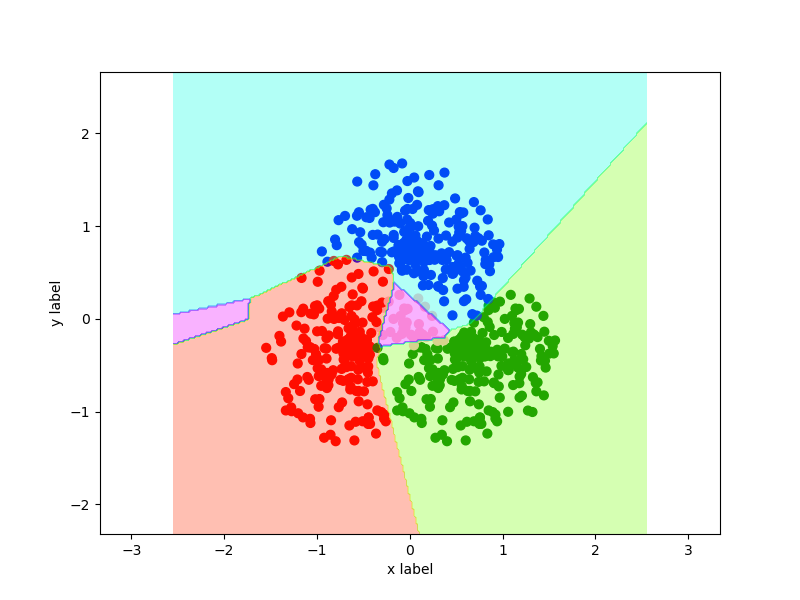

/home/oonisim/home/repository/git/oonisim/python_programs/nlp/src/drawing/functions.py:57: UserWarning: linewidths is ignored by contourf
  axes.contourf(grid[0], grid[1], predictions, cmap=plt.cm.gist_rainbow, alpha=0.3, linewidths=10)


In [82]:
fig, ax = plt.subplots(figsize=(8,6)) 
x_min, x_max = X[:, 1].min(), X[:, 1].max()
y_min, y_max = X[:, 2].min(), X[:, 2].max()
Y = COLOR_LABELS[T]

x_grid, y_grid, predictions = prediction_grid_2d(x_min, x_max, y_min, y_max, prediction)
plot_categorical_predictions(ax, [x_grid, y_grid], X, Y, predictions)

ax.set_xlabel('x label')
ax.set_ylabel('y label')
ax.axis('equal')
ax.grid()